# 0. Import packages

In [541]:
# # download packages

# !pip install contractions
# !pip install spacy
# !pip install gensim
# !pip install nltk
# !pip install spacy
# !pip install seaborn
# !pip install wordninja

In [3]:
# Dataframe
import pandas as pd
import numpy as np     
from tqdm import tqdm                      

from sklearn.preprocessing import LabelEncoder

# Cleaning
import pycld2 as cld2 # Language detection
import nltk
from nltk.stem import WordNetLemmatizer

# Import libraries
import nltk                                # Python library for NLP
import random                              # pseudo-random number generator
import contractions
import re                                  # library for regular expression operations
import string                              # for string operations
import wordninja
from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings
from nltk.stem import WordNetLemmatizer    # module for lemmatising

from stop_words import get_stop_words      # module for stop words that come with NLTK

import spacy                               # module for NLP
from spacy.language import Language        # library to get language of text

# for dealing with imbalanced dataset
from sklearn.utils import resample          # for category undersampling
import nlpaug.augmenter.word as naw         # for question augmentation

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# visualisation packages
import matplotlib.pyplot as plt
import seaborn as sns

# sk-learn packages for machinie learning models + others
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import accuracy_score
import time                                   # for timing the program

# package for fasttext
import csv                                    # for converting data into csv file
import fasttext                               # for fasttext             

# package for LSTM
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers



In [543]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')

# 1. Data Import and Clean

In this section, the dataset is imported while simple visualisation will be performed

## Import and read Yahoo Answers dataset

In [544]:
# Load csv file with headings
data = pd.read_csv('yahoo_answers.csv', header=None)
data.columns = ['y1', 'y2', 'y3', 'text']

A label encoder function was applied to normalise the label values.

In [545]:
# Apply labelencoder to y values to normamlize them
le = LabelEncoder()
data['y1'] = le.fit_transform(data['y1'])
data['y2'] = le.fit_transform(data['y2'])
data['y3'] = le.fit_transform(data['y3'])

# creating category labels for labelling purposes
category_labels = {0: 'Society & Culture', 1: 'Science & Mathematics', 2: 'Health', 3: 'Education & Reference',
                    4: 'Computers & Internet', 5: 'Sports', 6: 'Business & Finance', 7: 'Entertainment & Music',
                    8: 'Family & Relationships', 9: 'Politics & Government'}

In [546]:
# Number of rows in the dataframe
print("The number of rows in the dataframe is:", data.shape[0])
data.shape

# Number of labels
print("The number of labels is: ", len(le.classes_))

The number of rows in the dataframe is: 320000
The number of labels is:  10


## EDA on dataset

We want to explore on the distribution of each topic

In [547]:
# Compute the number of rows for each category
topic_count = pd.DataFrame(data.y1.value_counts())
topic_count['y2'] = data.y2.value_counts()
topic_count['y3'] = data.y3.value_counts()

# Name columns
topic_count.reset_index(inplace=True)
topic_count.columns = ['topic','count_y1','count_y2','count_y3']
topic_count.topic = topic_count.topic.map(category_labels)

# Compute percentage of reviews in each category
topic_count['percentage_y1'] = round(topic_count['count_y1'] * 100 / topic_count['count_y1'].sum(), 2)
topic_count['percentage_y2'] = round(topic_count['count_y2'] * 100 / topic_count['count_y2'].sum(), 2)
topic_count['percentage_y3'] = round(topic_count['count_y3'] * 100 / topic_count['count_y3'].sum(), 2)

topic_count

,topic,count_y1,count_y2,count_y3,percentage_y1,percentage_y2,percentage_y3
0,Business & Finance,75477,31430,31550,23.59,9.82,9.86
1,Computers & Internet,33752,45516,45523,10.55,14.22,14.23
2,Science & Mathematics,32366,46004,45984,10.11,14.38,14.37
3,Education & Reference,31981,23616,23559,9.99,7.38,7.36
4,Health,28567,47212,47105,8.93,14.75,14.72
5,Politics & Government,25825,24810,25017,8.07,7.75,7.82
6,Family & Relationships,25824,24863,24757,8.07,7.77,7.74
7,Sports,23269,25116,25149,7.27,7.85,7.86
8,Entertainment & Music,21602,25728,25599,6.75,8.04,8.00
9,Society & Culture,21337,25705,25757,6.67,8.03,8.05


The distribution of the first, second categories are visualised below in a bar chart. Here, it is noted that Business & Finance is a dominant topic in 
$y1$

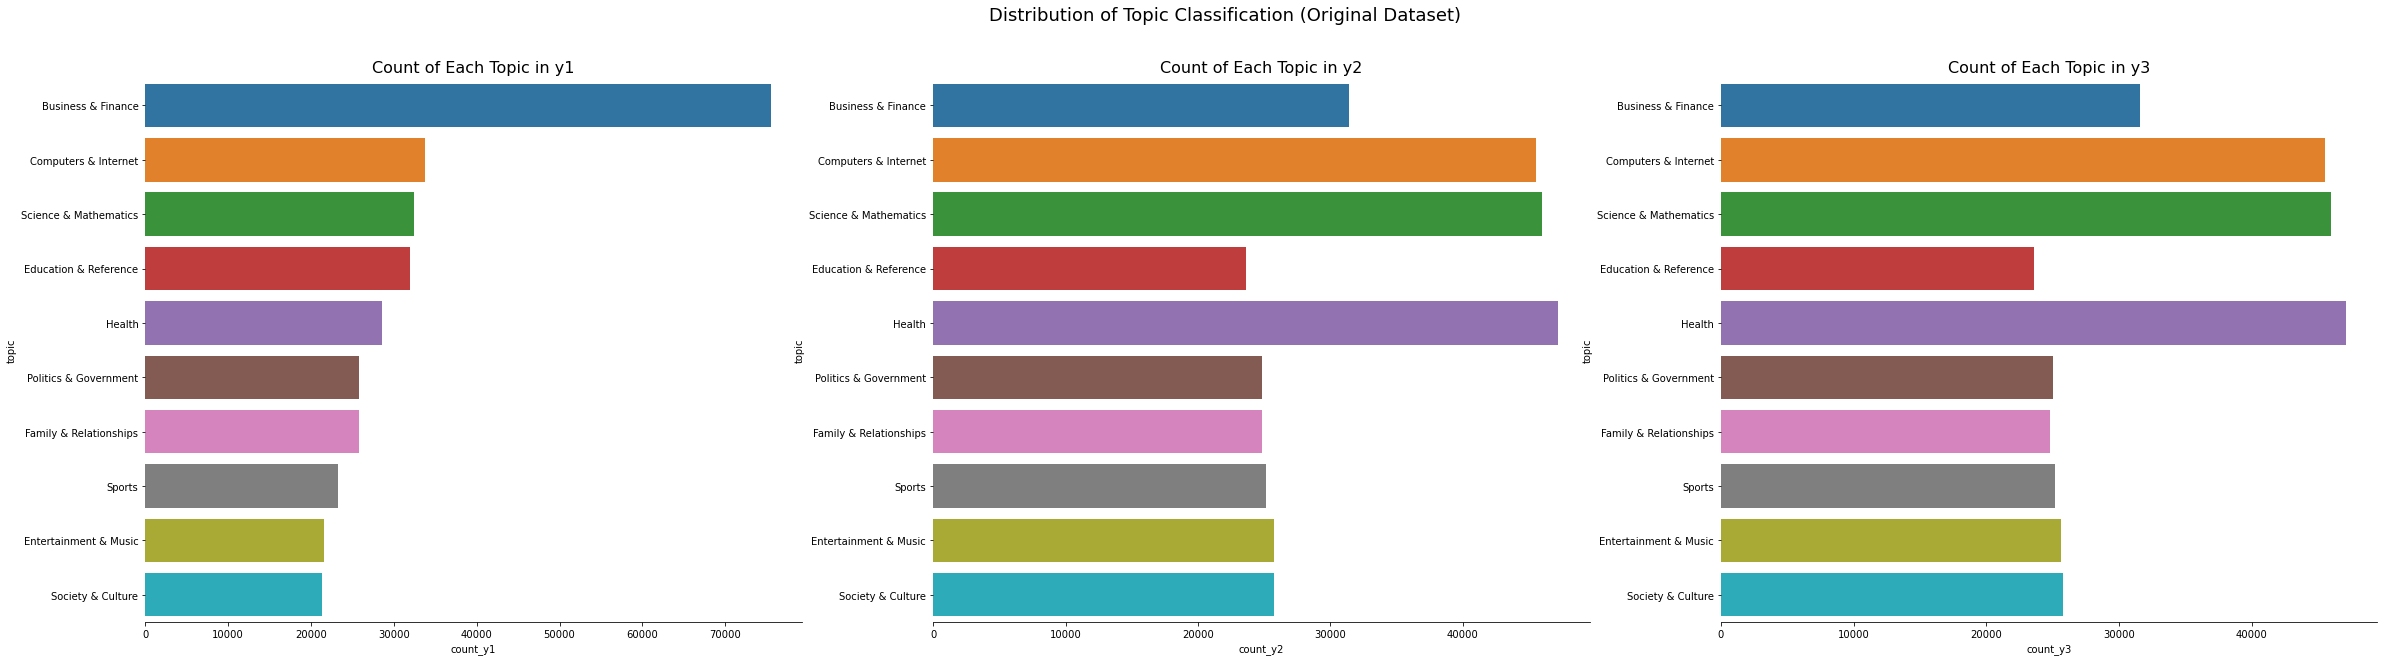

In [548]:
# Plot count of reviews in each category
fig, axes = plt.subplots(1, 3, figsize=(40, 10))
fig.suptitle('Distribution of Topic Classification (Original Dataset)', fontsize=18)

# Bar chart
sns.barplot(ax=axes[0], x='count_y1', y=topic_count['topic'], data=topic_count)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].set_title('Count of Each Topic in y1', fontsize=16)

# Bar chart
sns.barplot(ax=axes[1], x='count_y2', y=topic_count['topic'], data=topic_count)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].set_title('Count of Each Topic in y2', fontsize=16)

# Bar chart
sns.barplot(ax=axes[2], x='count_y3', y=topic_count['topic'], data=topic_count)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].spines['left'].set_visible(False)
axes[2].set_title('Count of Each Topic in y3', fontsize=16)

plt.show()

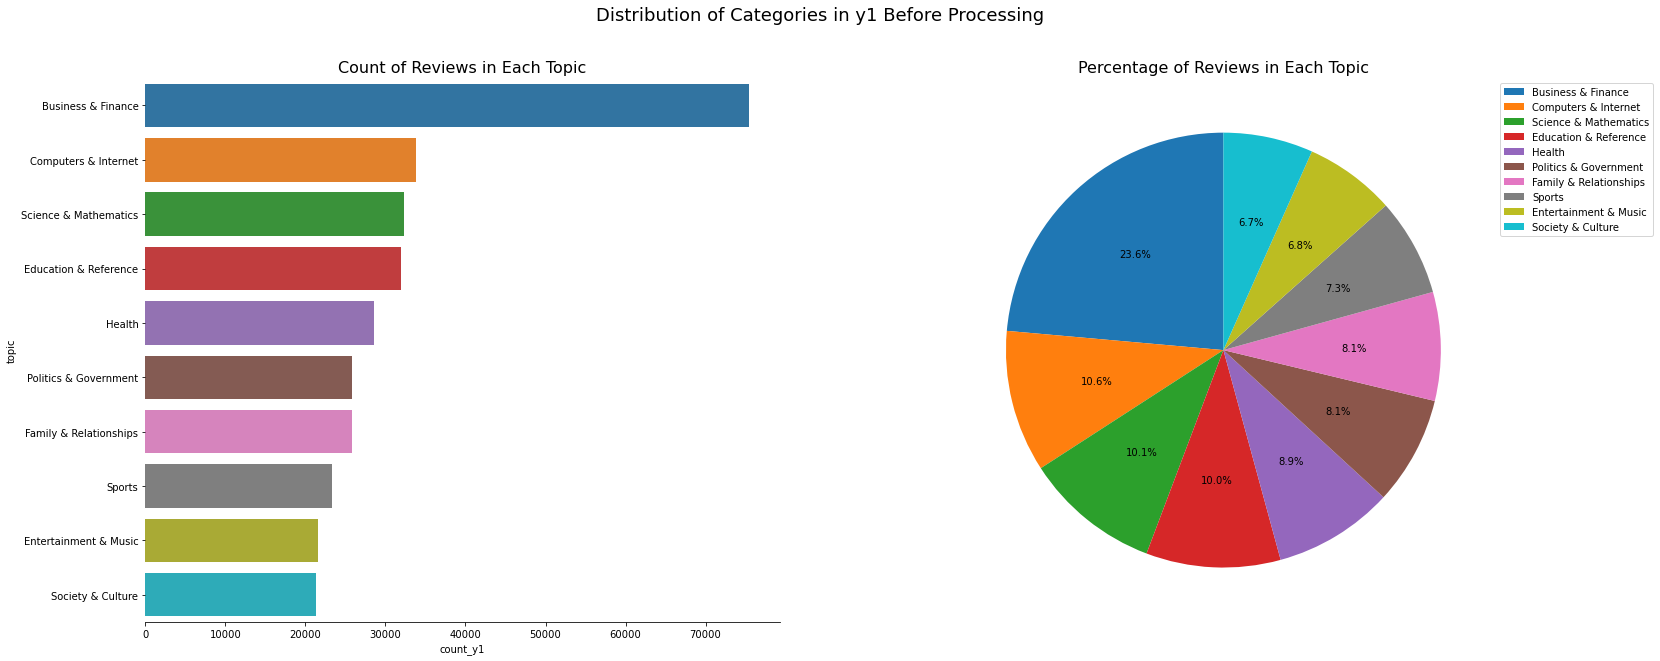

In [549]:
# Plot count of reviews in each category
fig, axes = plt.subplots(1, 2, figsize=(25, 10))
fig.suptitle('Distribution of Categories in y1 Before Processing', fontsize=18)

# Bar chart
sns.barplot(ax=axes[0], x='count_y1', y=topic_count['topic'], data=topic_count)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].set_title('Count of Reviews in Each Topic', fontsize=16)

# Pie chart
plt.pie(x='percentage_y1', data=topic_count, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Percentage of Reviews in Each Topic', fontsize=16)
plt.legend(topic_count['topic'], loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

## Clean Dataset

Before text classification, pre-processing of texts is required to improve overall quality, while removing noises. The following steps are carried out to 
clean the data:
1. Removal of foreign questinos
2. Remove duplications
3. Expand contractions
4. Lower the uppercase letters
5. Remove punctuations
6. Handle short and long questsions
7. Process sticky words

### Remove foreign questions from dataset

Some questions in the dataset are in a foreign language, and require removal. There were a total of 8570 foreign questions that required removing

In [550]:
# Remove foreign questions 
data['language'] = data['text'].apply(lambda x: [r[0] for r in cld2.detect(x)[2]])

In [551]:
data['language'].apply(lambda x: 'ENGLISH' in x).value_counts()

True     311430
False      8570
Name: language, dtype: int64

Examples of foreign questions can be found below

In [552]:
data[['text','language']].iloc[[52327, 229275, 223312]]

,text,language
52327,combien d'ambassadeurs sont accredites au sene...,"[FRENCH, Unknown, Unknown]"
229275,Kan enigiemand verstaan wat ek hier skryf? En ...,"[AFRIKAANS, Unknown, Unknown]"
223312,caracteristicas de un hombre mujeriego?,"[SPANISH, Unknown, Unknown]"


To remove these noises, foreign questions are dropped

In [553]:
# Filter out foreign questions
data = data[data['language'].apply(lambda x: 'ENGLISH' in x) == True]

In [554]:
# drop language column
data.drop(columns=['language'], inplace=True)

### Null Values

In [555]:
# check null values
data.isnull().sum()

y1      0
y2      0
y3      0
text    0
dtype: int64

### Duplicated Values

The dataset unfortunately contained a lot of duplicated questions. Although duplicated questions exist, these instances can also have duplicated labels. 
Overall, we decide to drop all of the duplicated instances

In [556]:
# select and view duplicated rows 
duplicate = data.loc[data.duplicated(keep=False)]

# print length of duplicate rows
print("Length of duplicate rows: ", len(duplicate))

duplicate.head(20)

Length of duplicate rows:  939


,y1,y2,y3,text
86,1,4,2,Why do we yawn?
333,1,4,6,Why is the sky blue?
424,6,1,4,Why are we here?
436,4,2,1,What's the best search engine?
470,3,9,8,How did language start?
550,6,1,2,How much wood would a woodchuck chuck if a woo...
583,6,1,2,what is the meaning of life?
625,2,6,1,what is the best way to quit smoking?
629,4,2,1,What is RSS?
806,7,0,9,one more riddle?


Comment: 

- There are 939 rows that are duplicated in all 4 columns.

In [557]:
# data shape before removing duplicates
print("Shape of data (rows, cols): ", data.shape)

# drop duplicates and keep first row
data = data.drop_duplicates(keep='first')

# data shape after removing duplicates
print("Shape of data (rows, cols): ", data.shape)

Shape of data (rows, cols):  (311430, 4)
Shape of data (rows, cols):  (310892, 4)


In [558]:
# print duplicate rows for each column
data.describe(include='all')

,y1,y2,y3,text
count,310892.000000,310892.000000,310892.000000,310892
unique,NaN,NaN,NaN,307539
top,NaN,NaN,NaN,what is love?
freq,NaN,NaN,NaN,29
mean,4.629357,4.093341,4.095808,NaN
std,2.643079,2.759596,2.760717,NaN
min,0.000000,0.000000,0.000000,NaN
25%,2.000000,2.000000,2.000000,NaN
50%,5.000000,4.000000,4.000000,NaN
75%,6.000000,6.000000,6.000000,NaN


Comment:

- In `text` column, there are 305160 unique rows, which means that there are still duplicated questions.

In [559]:
# verify duplicates
data.text.duplicated(keep=False).value_counts()

False    305160
True       5732
Name: text, dtype: int64

Comment:

- For `text` column, there 5,732 entries are duplicated.

In [560]:
# view duplicate rows
text_duplicate = data.loc[data.text.duplicated(keep=False)]

text_duplicate.head(20)

,y1,y2,y3,text
67,8,9,0,How do you know if you're in love?
86,1,4,2,Why do we yawn?
150,6,2,1,How do I write a resume?
207,3,9,5,What does RSVP stand for?
285,1,6,4,"Which came first, the chicken or the egg?"
292,0,8,7,What is the meaning of life?
333,1,4,6,Why is the sky blue?
351,1,4,6,Where do babies come from?
393,1,4,6,why is the earth round?
424,6,1,4,Why are we here?


Comment:

- As shown, there are identical questions, but classified topics are different. Which raises an issue to data quality when building model.

- Hence, dropping duplicated values anonymously to prevent bias.

In [561]:
# data shape before removing duplicates
print("Shape of data (rows, cols): ", data.shape)

# drop duplicates in text column and keep first row
data = data.drop_duplicates(subset='text', keep=False)

# data shape after removing duplicates
print("Shape of data after duplicate removal (rows, cols): ", data.shape)

Shape of data (rows, cols):  (310892, 4)
Shape of data after duplicate removal (rows, cols):  (305160, 4)


### Expand Contractions

We also want clean contractions. These are words such as "couldn't" or "haven't", which can be converted to "could not" and "have not" respectively.

In [562]:
# define the function to expand words
def expand_contractions(text):
  
    # creating an empty list
    expanded_words = []

    # iterate through each word in each sentence   
    for word in text.split():

        # using contractions.fix to expand the shortened words
        expanded_words.append(contractions.fix(word))
        text = " ".join(expanded_words)    
    
    return text  

# apply the new function
data['expanded'] = data['text'].apply(lambda row:expand_contractions(row))

data.head()

,y1,y2,y3,text,expanded
0,4,6,1,why doesn't an optical mouse work on a glass t...,why does not an optical mouse work on a glass ...
1,5,3,7,What is the best off-road motorcycle trail ?,What is the best off-road motorcycle trail ?
2,2,6,1,What is Trans Fat? How to reduce that?,What is Trans Fat? How to reduce that?
3,6,1,4,How many planes Fedex has?,How many planes Fedex has?
4,6,1,4,"In the san francisco bay area, does it make se...","In the san francisco bay area, does it make se..."


### Lower Uppercase

This lowercase any capital letters that are in the dataset. This allows capitals and lowercase words to be recognised as the same

In [563]:
# lower uppercase words
data['lowercased'] = data['expanded'].apply(lambda row: row.lower()) # iterate through each row of data frame

data.head()

,y1,y2,y3,text,expanded,lowercased
0,4,6,1,why doesn't an optical mouse work on a glass t...,why does not an optical mouse work on a glass ...,why does not an optical mouse work on a glass ...
1,5,3,7,What is the best off-road motorcycle trail ?,What is the best off-road motorcycle trail ?,what is the best off-road motorcycle trail ?
2,2,6,1,What is Trans Fat? How to reduce that?,What is Trans Fat? How to reduce that?,what is trans fat? how to reduce that?
3,6,1,4,How many planes Fedex has?,How many planes Fedex has?,how many planes fedex has?
4,6,1,4,"In the san francisco bay area, does it make se...","In the san francisco bay area, does it make se...","in the san francisco bay area, does it make se..."


### Remove Punctuations

Punctuations are removed to alleviate additional noises as they do not contribute much information

In [564]:
# view punctuation
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [565]:
# defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation]) # iterate through each letter and remove punctuation, then join letters as a sentence
    return punctuationfree

# storing the puntuation free text
data['punctuation_free'] = data['lowercased'].apply(lambda row:remove_punctuation(row))
data.head()

,y1,y2,y3,text,expanded,lowercased,punctuation_free
0,4,6,1,why doesn't an optical mouse work on a glass t...,why does not an optical mouse work on a glass ...,why does not an optical mouse work on a glass ...,why does not an optical mouse work on a glass ...
1,5,3,7,What is the best off-road motorcycle trail ?,What is the best off-road motorcycle trail ?,what is the best off-road motorcycle trail ?,what is the best offroad motorcycle trail
2,2,6,1,What is Trans Fat? How to reduce that?,What is Trans Fat? How to reduce that?,what is trans fat? how to reduce that?,what is trans fat how to reduce that
3,6,1,4,How many planes Fedex has?,How many planes Fedex has?,how many planes fedex has?,how many planes fedex has
4,6,1,4,"In the san francisco bay area, does it make se...","In the san francisco bay area, does it make se...","in the san francisco bay area, does it make se...",in the san francisco bay area does it make sen...


In [566]:
# check if data is null after removing punctuations
data['punctuation_free'].isnull().sum()

0

### Handle Short/Long text & Sticky Words

In here, we deal with two issues: 
1) word lengths and whether questions with a short or long sentences should be kept in the analysis
2) expanding "sticky words"

In [567]:
# calculate the number of words in each review
data['words'] = [len(x.split()) for x in data['punctuation_free']]

# print max and min of words in each review
print("Max words: ", data['words'].max())
print("Min words: ", data['words'].min())

Max words:  39
Min words:  1


In [568]:
# print number of text with min words
print("Number of text with min words:", len(data.loc[data['words'] == data['words'].min()]['punctuation_free']))

Number of text with min words: 132


In [569]:
# print number of text with max words
print("Number of text with max words:", len(data.loc[data['words'] == data['words'].max()]['punctuation_free']))

Number of text with max words: 1


In [570]:
# print text of text with min words
data.loc[data['words'] == data['words'].min()]

,y1,y2,y3,text,expanded,lowercased,punctuation_free,words
840,4,1,2,E-commerce?,E-commerce?,e-commerce?,ecommerce,1
1501,5,3,7,dallascowboys?,dallascowboys?,dallascowboys?,dallascowboys,1
2318,5,3,7,wheredoihuntinvirginia?andisthereasysteminplac...,wheredoihuntinvirginia?andisthereasysteminplac...,wheredoihuntinvirginia?andisthereasysteminplac...,wheredoihuntinvirginiaandisthereasysteminplace...,1
5082,1,6,4,vocaltronics?,vocaltronics?,vocaltronics?,vocaltronics,1
9289,6,1,4,Occupations?,Occupations?,occupations?,occupations,1
...,...,...,...,...,...,...,...,...
313115,6,2,1,"""refunds""?","""refunds""?","""refunds""?",refunds,1
313382,9,5,7,immirgration?,immirgration?,immirgration?,immirgration,1
317380,6,2,4,GLOBALlZATION!!!!!!!?,GLOBALlZATION!!!!!!!?,globallzation!!!!!!!?,globallzation,1
319787,6,2,4,value-at-risk?,value-at-risk?,value-at-risk?,valueatrisk,1


In [571]:
# print text of text with max words
data.loc[data['words'] == data['words'].max()]

,y1,y2,y3,text,expanded,lowercased,punctuation_free,words
177426,6,2,1,d d d d does c c c c coffee g g g g g g give...,d d d d does c c c c coffee g g g g g g give y...,d d d d does c c c c coffee g g g g g g give y...,d d d d does c c c c coffee g g g g g g give y...,39


#### Sticky Words

Comment:

- There are 38 texts with only one word, moreover, these are words that stick to each other without space.

- We split it using wordninja package, apply for all data rows.

In [572]:
# testify wordninja
wordninja.split('wethepeopleoftheunitedstatesinordertoformamoreperfectunionestablishjusticeinsuredomestictranquilityprovideforthecommondefencepromotethegeneralwelfareandsecuretheblessingsoflibertytoourselvesandourposteritydoordainandestablishthisconstitutionfortheunitedstatesofamerica')

['we',
 'the',
 'people',
 'of',
 'the',
 'united',
 'states',
 'in',
 'order',
 'to',
 'form',
 'a',
 'more',
 'perfect',
 'union',
 'establish',
 'justice',
 'in',
 'sure',
 'domestic',
 'tranquility',
 'provide',
 'for',
 'the',
 'common',
 'defence',
 'promote',
 'the',
 'general',
 'welfare',
 'and',
 'secure',
 'the',
 'blessings',
 'of',
 'liberty',
 'to',
 'ourselves',
 'and',
 'our',
 'posterity',
 'do',
 'ordain',
 'and',
 'establish',
 'this',
 'constitution',
 'for',
 'the',
 'united',
 'states',
 'of',
 'america']

In [573]:
# testify wordninja
' '.join([word for word in wordninja.split('onestepcash')])

'one step cash'

In [574]:
# create vocabulary of words
vocab = set()
corpus = [x.split() for x in data['punctuation_free'].tolist()]

# count distinct words in each review
for sentence in corpus:
  for word in sentence:
    vocab.add(word)

print("Number of distinct words in before splitting sticky words: ", len(vocab))

Number of distinct words in before splitting sticky words:  125498


In [576]:
# apply to data
data['no_sticky'] = data['punctuation_free'].apply(lambda row: ' '.join([word for word in wordninja.split(row)]))

In [577]:
# create vocabulary of words
vocab = set()
corpus = [x.split() for x in data['no_sticky'].tolist()]

# count distinct words in each review
for sentence in corpus:
  for word in sentence:
    vocab.add(word)

print("Number of distinct words in after splitting sticky words: ", len(vocab))

Number of distinct words in after splitting sticky words:  51670


In [578]:
# review text with 1 words
data.loc[data['words'] == data['words'].min()]['no_sticky']

840                                              e commerce
1501                                         dallas cowboys
2318      where doi hunt in virginia and is there a syst...
5082                                         vocal tronic s
9289                                            occupations
                                ...                        
313115                                              refunds
313382                                      im mir g ration
317380                                      global lz ation
319787                                        value at risk
319968                                             describe
Name: no_sticky, Length: 132, dtype: object

In [579]:
# review text with max words
data.loc[data['words'] == data['words'].max()]['no_sticky']

177426    d d d d does c c c c coffee g g g g g g give y...
Name: no_sticky, dtype: object

In [580]:
# calculate the number of words in each review
data['words_2'] = [len(x.split()) for x in data['no_sticky']]

# print max and min of words in each review
print("Max words: ", data['words_2'].max())
print("Min words: ", data['words_2'].min())

Max words:  46
Min words:  1


In [581]:
# print text of text with min words
data.loc[data['words_2'] == data['words_2'].min()]['text']

9289                          Occupations?
25986     AFTERLIFE???????????????????????
27528                        firefighting?
55325                        CHEERLEADING?
58285                     Methamphetamine?
61227                        Melatonin...?
62402                         unsubscribe?
62611                          Obituaries?
65550                         Methodology?
83372                         girlfriends?
83433                         Mathematics?
97134                           Equation??
121328                        Application?
121402                         moonscapes?
140846                       Rejection...?
143568                        Mockingbird?
152736                        Supplements?
161099                  Reproduction??????
168491                         Relocation?
181971                         perception?
185467                       Wireless....?
193060                        shoplifting?
194028                        acupuncture?
194697     

In [582]:
data.iloc[0]

y1                                                                  4
y2                                                                  6
y3                                                                  1
text                why doesn't an optical mouse work on a glass t...
expanded            why does not an optical mouse work on a glass ...
lowercased          why does not an optical mouse work on a glass ...
punctuation_free    why does not an optical mouse work on a glass ...
words                                                              11
no_sticky           why does not an optical mouse work on a glass ...
words_2                                                            11
Name: 0, dtype: object

In [583]:
data = data[data['words_2'] > data['words_2'].min()]

#### Set Min and Max Parameters for Word Length

In [584]:
# print max and min of words in each review
print("Max words: ", data['words_2'].max())
print("Min words: ", data['words_2'].min())

Max words:  46
Min words:  2


In [585]:
len(data[data['words_2'] > 31])

65

In [586]:
data[data['words_2'] > 31]

,y1,y2,y3,text,expanded,lowercased,punctuation_free,words,no_sticky,words_2
9227,8,5,3,wuld u get mad if ur bf/gf went to the movies ...,wuld you get mad if you are bf/gf went to the ...,wuld you get mad if you are bf/gf went to the ...,wuld you get mad if you are bfgf went to the m...,27,wu ld you get mad if you are bf gf went to the...,34
16055,9,5,0,if u were being held hostage by terorist's wld...,if you were being held hostage by terorist's w...,if you were being held hostage by terorist's w...,if you were being held hostage by terorists wl...,27,if you were being held hostage by ter or is ts...,34
17181,1,6,2,how would u balance K2Cr2O7+Pb(C2H3O2)2+H2O yi...,how would you balance K2Cr2O7+Pb(C2H3O2)2+H2O ...,how would you balance k2cr2o7+pb(c2h3o2)2+h2o ...,how would you balance k2cr2o7pbc2h3o22h2o yiel...,7,how would you balance k 2 cr 2 o 7 p bc 2 h 3 ...,36
20393,1,4,2,How would u balance Na2SO4+H2O+ZnCl2+UO2(C2H3O...,How would you balance Na2SO4+H2O+ZnCl2+UO2(C2H...,how would you balance na2so4+h2o+zncl2+uo2(c2h...,how would you balance na2so4h2ozncl2uo2c2h3o22...,7,how would you balance na 2 so 4 h 2 o zncl 2 u...,46
24824,8,3,0,Wat shud i do wen saw my bestfrend's grlfrnd k...,Wat shud i do wen saw my bestfrend's grlfrnd k...,wat shud i do wen saw my bestfrend's grlfrnd k...,wat shud i do wen saw my bestfrends grlfrnd ki...,21,wat s hud i do wen saw my best fr ends gr l fr...,32
...,...,...,...,...,...,...,...,...,...,...
303613,8,7,5,"I prposd my bst frend,but she said she dosnt f...","I prposd my bst frend,but she said she dosnt f...","i prposd my bst frend,but she said she dosnt f...",i prposd my bst frendbut she said she dosnt fe...,21,i pr pos d my bst fr end but she said she dos ...,35
303923,7,3,5,"In the song, Uhn Tiss Uhn Tiss Uhn Tiss by the...","In the song, Uhn Tiss Uhn Tiss Uhn Tiss by the...","in the song, uhn tiss uhn tiss uhn tiss by the...",in the song uhn tiss uhn tiss uhn tiss by the ...,22,in the song uh n tis s uh n tis s uh n tis s b...,34
305494,8,9,5,ive been with my fella 7 monthes i met him on ...,i have been with my fella 7 monthes i met him ...,i have been with my fella 7 monthes i met him ...,i have been with my fella 7 monthes i met him ...,29,i have been with my fella 7 mon the s i met hi...,33
317964,6,1,4,temorarilly separated w/my husdand.he ask me2r...,temorarilly separated w/my husdand.he ask me2r...,temorarilly separated w/my husdand.he ask me2r...,temorarilly separated wmy husdandhe ask me2ren...,17,tem or ar illy separated w my h usd and he ask...,32


In [587]:
data[data['words_2'] == data['words_2'].min()].tail()

,y1,y2,y3,text,expanded,lowercased,punctuation_free,words,no_sticky,words_2
319099,6,1,4,Richard oakley?,Richard oakley?,richard oakley?,richard oakley,2,richard oakley,2
319166,6,1,2,tennant rights?,tennant rights?,tennant rights?,tennant rights,2,tennant rights,2
319171,4,1,2,yahoo emotions?,yahoo emotions?,yahoo emotions?,yahoo emotions,2,yahoo emotions,2
319388,2,4,6,natural laxatives?,natural laxatives?,natural laxatives?,natural laxatives,2,natural laxatives,2
319407,2,6,1,Belly Dancing?,Belly Dancing?,belly dancing?,belly dancing,2,belly dancing,2


In [588]:
# review length in terms of number of words
data['words_2'].describe()

count    305113.000000
mean         11.754711
std           5.463938
min           2.000000
25%           8.000000
50%          11.000000
75%          15.000000
max          46.000000
Name: words_2, dtype: float64

Comment:

- 75% of texts has only 15 words.

- 50% of text has only 11 words.

- 25% of text has only 7 words.

In [589]:
# review length in terms of number of words per topic
data.groupby(['y1'])['words_2'].describe()

,count,mean,std,min,25%,50%,75%,max
y1,,,,,,,,
0,20438.0,11.457824,5.225076,2.0,7.0,11.0,15.0,34.0
1,30370.0,10.997728,5.209032,2.0,7.0,10.0,14.0,46.0
2,27430.0,11.826139,5.532051,2.0,8.0,11.0,15.0,32.0
3,30315.0,11.087317,5.143612,2.0,7.0,10.0,14.0,35.0
4,32511.0,12.551998,5.628742,2.0,8.0,12.0,17.0,34.0
5,22237.0,11.374061,4.929192,2.0,8.0,10.0,14.0,33.0
6,71943.0,11.746786,5.542695,2.0,7.0,11.0,15.0,39.0
7,20496.0,11.095141,5.181735,2.0,7.0,10.0,14.0,34.0
8,24460.0,13.166517,6.300698,2.0,8.0,12.0,18.0,39.0


Comment:

- The distribution of words amongst topics is relatively similar.

- 75% of words in 10 topics are ranging from 14-18 words, which is not significantly different.

- However, the max words in each category is widely varied.

In [590]:
# create table to 
words_2 = pd.DataFrame(data.words_2)
words_2['y1'] = data['y1']
words_2

,words_2,y1
0,11,4
1,8,5
2,8,2
3,5,6
4,14,6
...,...,...
319995,11,2
319996,4,1
319997,20,6
319998,14,9


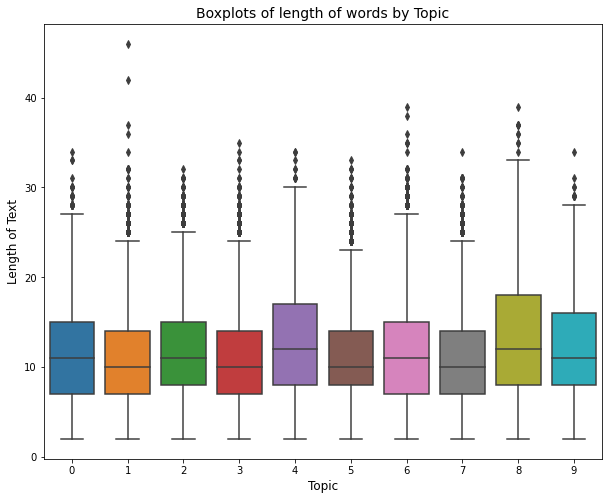

In [591]:
# draw boxplot to view distribution

fig = plt.subplots(1, 1, figsize=(10, 8))

sns.boxplot(x='y1', y='words_2', data=words_2)

plt.title('Boxplots of length of words by Topic', size=14)
plt.xlabel('Topic', size=12)
plt.ylabel('Length of Text', size=12)

plt.show()

/opt/anaconda3/envs/nlp_clone/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


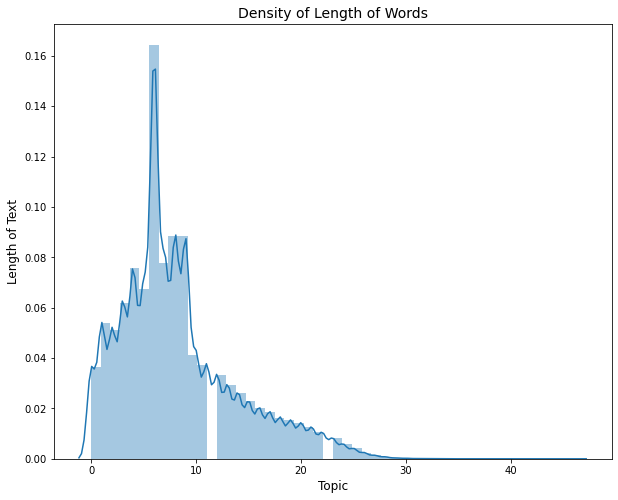

In [592]:
# density plot of word length

fig = plt.subplots(1, 1, figsize=(10, 8))

sns.distplot(words_2)

plt.title('Density of Length of Words', size=14)
plt.xlabel('Topic', size=12)
plt.ylabel('Length of Text', size=12)

plt.show()

After testing, the min and max text size that gave the best accuracy was min=3 and max=25

In [593]:
# decide minimum and maximum number of words in a review
# set parameter to minimum number of words in a review


min_text_size = 3
max_text_size = 25

# filter rows with set parameters
# count number of reviews with more than minimum number of words and less than maximum number of words
data[(data['words_2'] >= min_text_size) & (data['words_2'] <= max_text_size)].count()

y1                  300835
y2                  300835
y3                  300835
text                300835
expanded            300835
lowercased          300835
punctuation_free    300835
words               300835
no_sticky           300835
words_2             300835
dtype: int64

In [594]:
# filter data with set parameters 
data = data[(data['words_2'] >= min_text_size) & (data['words_2'] <= max_text_size)]

### EDA and Visualisation of Data Distribution after Pre-processsing

In [754]:
print("The number of questions left after pre-processing is: ", len(data))

The number of questions left after pre-processing is:  300835


In [595]:
# Compute the number of rows for each category
topic_count = pd.DataFrame(data.y1.value_counts())
topic_count['y2'] = data.y2.value_counts()
topic_count['y3'] = data.y3.value_counts()

# Name columns
topic_count.reset_index(inplace=True)
topic_count.columns = ['topic','count_y1','count_y2','count_y3']
topic_count.topic = topic_count.topic.map(category_labels)

# Compute percentage of reviews in each category
topic_count['percentage_y1'] = round(topic_count['count_y1'] * 100 / topic_count['count_y1'].sum(), 2)
topic_count['percentage_y2'] = round(topic_count['count_y2'] * 100 / topic_count['count_y2'].sum(), 2)
topic_count['percentage_y3'] = round(topic_count['count_y3'] * 100 / topic_count['count_y3'].sum(), 2)

topic_count

,topic,count_y1,count_y2,count_y3,percentage_y1,percentage_y2,percentage_y3
0,Business & Finance,70919,29578,29706,23.57,9.83,9.87
1,Computers & Internet,32022,42663,42737,10.64,14.18,14.21
2,Science & Mathematics,30088,43475,43281,10.00,14.45,14.39
3,Education & Reference,29986,22199,22126,9.97,7.38,7.35
4,Health,26985,44298,44290,8.97,14.73,14.72
5,Politics & Government,24736,23229,23459,8.22,7.72,7.80
6,Family & Relationships,23524,23529,23381,7.82,7.82,7.77
7,Sports,22043,23569,23591,7.33,7.83,7.84
8,Entertainment & Music,20284,24170,24069,6.74,8.03,8.00
9,Society & Culture,20248,24125,24195,6.73,8.02,8.04


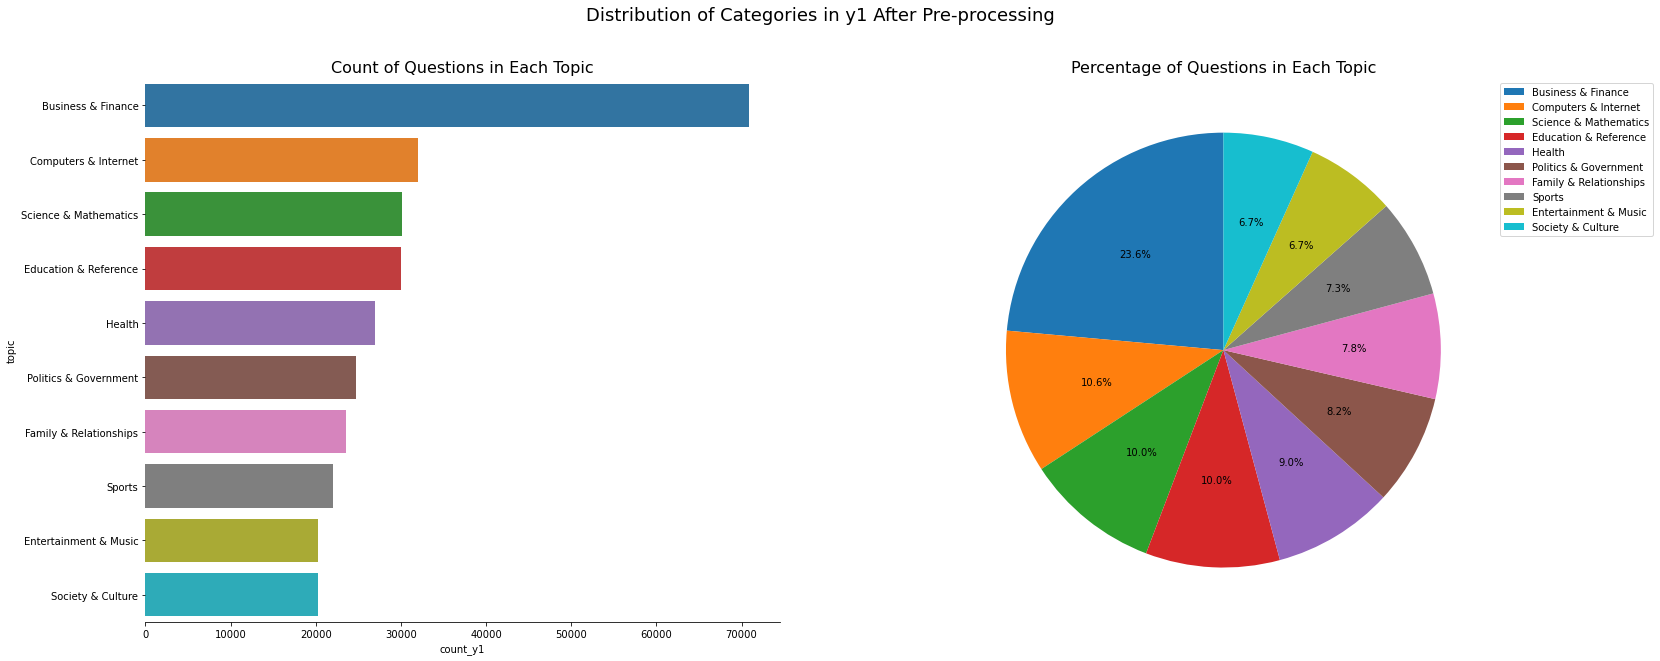

In [621]:
# Plot count of reviews in each category
fig, axes = plt.subplots(1, 2, figsize=(25, 10))
fig.suptitle('Distribution of Categories in y1 After Pre-processing', fontsize=18)

# Bar chart
sns.barplot(ax=axes[0], x='count_y1', y=topic_count['topic'], data=topic_count)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].set_title('Count of Questions in Each Topic', fontsize=16)

# Pie chart
plt.pie(x='percentage_y1', data=topic_count, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Percentage of Questions in Each Topic', fontsize=16)
plt.legend(topic_count['topic'], loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

# 2. Preprocessing Methodologies 

## Converting Text into Vectors - Experiment

In this section, we test on whether to utilise BoW or TF-IDF for our text representation in our machine learning 
models. Although both methodologies offer a way to represent text in a vector space, a test was run to observe 
whether to use one or the other

### BoW or TF-IDF

In [282]:
# Use train_test_split to split training data into training and validation sets
X_train, X_test, y_train_full, y_test_full = train_test_split(data["no_sticky"].to_numpy(),
                                                                           data[['y1', 'y2', 'y3']],
                                                                            test_size=0.1, # dedicate 10% of samples to test set
                                                                            random_state=66) # random state for reproducibility
y_train = y_train_full['y1'].to_numpy()
y_test = y_test_full['y1'].to_numpy()


In [283]:
## Tfidf
tfidf = TfidfVectorizer(stop_words='english', min_df = 2, token_pattern=r'\b[^\d\W_]+\b')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# CountVectorizer
count_vect = CountVectorizer(stop_words='english', min_df = 2, token_pattern=r'\b[^\d\W_]+\b')
X_train_count = count_vect.fit_transform(X_train)
X_test_count = count_vect.transform(X_test)

# create a logistic regression model
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, random_state=66)
logreg.fit(X_train_tfidf, y_train)
y_pred_tfidf = logreg.predict(X_test_tfidf)
print('Logistic Regression - Tfidf')
print(classification_report(y_test, y_pred_tfidf))

# test count_vect vs tfidf
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, random_state=66)
logreg.fit(X_train_count, y_train)
y_pred_count = logreg.predict(X_test_count)
print('Logistic Regression - Count')
print(classification_report(y_test, y_pred_count))




Logistic Regression - Tfidf
              precision    recall  f1-score   support

           0       0.57      0.35      0.44      2007
           1       0.61      0.65      0.63      2916
           2       0.71      0.70      0.70      2759
           3       0.52      0.40      0.46      2958
           4       0.80      0.77      0.79      3193
           5       0.85      0.75      0.80      2232
           6       0.47      0.63      0.54      7079
           7       0.73      0.60      0.66      2015
           8       0.68      0.62      0.65      2388
           9       0.70      0.62      0.66      2522

    accuracy                           0.62     30069
   macro avg       0.66      0.61      0.63     30069
weighted avg       0.63      0.62      0.62     30069

Logistic Regression - Count
              precision    recall  f1-score   support

           0       0.54      0.36      0.43      2007
           1       0.61      0.63      0.62      2916
           2       0.7

Overall, TF-IDF obtained a better accuracy score than BoW, although it is not significant. Despite so, we will opt to use the TFIDFVectorizer function going forward

## Dealing with Imbalanced Dataset - Experiment

Due to the imbalanced nature of our labels, we will test whether dealing with the imbalanced distribution will help improve model accuracy. 
Three methodologies were tested:
1. Category undersampling
2. Synonym Data Augmentation
3. SMOTE

In [620]:
data_imbalanced_test = data.copy()

### Create baseline model and dictionary

Firstly, a baseline model is created for comparison

In [218]:
imbalanced_dict = {}

In [219]:
data_imbalanced_test

,y1,y2,y3,text,expanded,lowercased,punctuation_free,no_sticky,words_2
0,4,6,1,why doesn't an optical mouse work on a glass t...,why does not an optical mouse work on a glass ...,why does not an optical mouse work on a glass ...,why does not an optical mouse work on a glass ...,why does not an optical mouse work on a glass ...,11
1,5,3,7,What is the best off-road motorcycle trail ?,What is the best off-road motorcycle trail ?,what is the best off-road motorcycle trail ?,what is the best offroad motorcycle trail,what is the best off road motorcycle trail,8
2,2,6,1,What is Trans Fat? How to reduce that?,What is Trans Fat? How to reduce that?,what is trans fat? how to reduce that?,what is trans fat how to reduce that,what is trans fat how to reduce that,8
3,6,1,4,How many planes Fedex has?,How many planes Fedex has?,how many planes fedex has?,how many planes fedex has,how many planes fedex has,5
4,6,1,4,"In the san francisco bay area, does it make se...","In the san francisco bay area, does it make se...","in the san francisco bay area, does it make se...",in the san francisco bay area does it make sen...,in the san francisco bay area does it make sen...,14
...,...,...,...,...,...,...,...,...,...
319995,2,4,6,How can I get rid of dark circles under my eyes?,How can I get rid of dark circles under my eyes?,how can i get rid of dark circles under my eyes?,how can i get rid of dark circles under my eyes,how can i get rid of dark circles under my eyes,11
319996,1,6,4,Do humans have instincts?,Do humans have instincts?,do humans have instincts?,do humans have instincts,do humans have instincts,4
319997,6,1,4,How can I sell a collectable on ebay without a...,How can I sell a collectable on ebay without a...,how can i sell a collectable on ebay without a...,how can i sell a collectable on ebay without a...,how can i sell a collectable on ebay without a...,20
319998,9,0,7,What is Communist Party?it likes more religion...,What is Communist Party?it likes more religion...,what is communist party?it likes more religion...,what is communist partyit likes more religion ...,what is communist party it likes more religion...,14


In [224]:
## Baseline model

# Use train_test_split to split training data into training and validation sets
X_train, X_test, y_train_full, y_test_full = train_test_split(data_imbalanced_test["no_sticky"].to_numpy(),
                                                                           data_imbalanced_test[['y1', 'y2', 'y3']],
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=66) # random state for reproducibility

y_train = y_train_full['y1'].to_numpy()
y_test = y_test_full['y1'].to_numpy()

# create vector form of text
tfidf = TfidfVectorizer(stop_words='english', min_df = 2, token_pattern=r'\b[^\d\W_]+\b')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


# create a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=66)
start = time.time()

logreg.fit(X_train_tfidf, y_train)
stop = time.time()
logreg_time = stop - start
# predict on test set
y_pred_prob = logreg.predict_proba(X_test_tfidf)
y_pred = logreg.predict(X_test_tfidf)

print(classification_report(y_test, y_pred, target_names=category_labels.values()))

imbalanced_dict['baseline_model'] = {'accuracy': logreg.score(X_test_tfidf, y_test)}

                        precision    recall  f1-score   support

     Society & Culture       0.56      0.34      0.42      2007
 Science & Mathematics       0.61      0.66      0.63      2916
                Health       0.72      0.70      0.71      2759
 Education & Reference       0.51      0.43      0.46      2958
  Computers & Internet       0.81      0.77      0.79      3193
                Sports       0.85      0.74      0.79      2232
    Business & Finance       0.48      0.63      0.55      7079
 Entertainment & Music       0.73      0.60      0.66      2015
Family & Relationships       0.68      0.66      0.67      2388
 Politics & Government       0.71      0.63      0.67      2522

              accuracy                           0.62     30069
             macro avg       0.67      0.61      0.63     30069
          weighted avg       0.64      0.62      0.62     30069



In [225]:
imbalanced_dict

{'baseline_model': {'accuracy': 0.6232664870797167}}

### Category Undersampling

Category undersampling sought to randomly undersample categories until all labels are equally distributed

In [226]:
# Split data into train and test sets
X_train, X_test, y_train_full, y_test_full = train_test_split(data_imbalanced_test['no_sticky'], data_imbalanced_test[['y1', 'y2', 'y3']], test_size=0.1, random_state=66)

X_train_full = pd.concat([X_train, y_train_full], axis=1)

In [227]:
# Create subset of training set for each class

data_0 = X_train_full[X_train_full['y1']==0]
data_1 = X_train_full[X_train_full['y1']==1]
data_2 = X_train_full[X_train_full['y1']==2]
data_3 = X_train_full[X_train_full['y1']==3]
data_4 = X_train_full[X_train_full['y1']==4]
data_5 = X_train_full[X_train_full['y1']==5]
data_6 = X_train_full[X_train_full['y1']==6]
data_7 = X_train_full[X_train_full['y1']==7]
data_8 = X_train_full[X_train_full['y1']==8]
data_9 = X_train_full[X_train_full['y1']==9]

In [228]:
# Print out shape of each subset

print("Shape of full dataset: {}".format(X_train_full.shape))
print("Shape of data_0: {}".format(data_0.shape))
print("Shape of data_1: {}".format(data_1.shape))
print("Shape of data_2: {}".format(data_2.shape))
print("Shape of data_3: {}".format(data_3.shape))
print("Shape of data_4: {}".format(data_4.shape))
print("Shape of data_5: {}".format(data_5.shape))
print("Shape of data_6: {}".format(data_6.shape))
print("Shape of data_7: {}".format(data_7.shape))
print("Shape of data_8: {}".format(data_8.shape))
print("Shape of data_9: {}".format(data_9.shape))

Shape of full dataset: (270618, 4)
Shape of data_0: (18239, 4)
Shape of data_1: (27132, 4)
Shape of data_2: (24215, 4)
Shape of data_3: (27016, 4)
Shape of data_4: (28813, 4)
Shape of data_5: (19801, 4)
Shape of data_6: (63794, 4)
Shape of data_7: (18264, 4)
Shape of data_8: (21133, 4)
Shape of data_9: (22211, 4)


As we can observe in the cell above, data_6 (Business & Finance) contains the most count of questions, while 
the lowest is data_0 (Society & Culture). 

We will undersample so that every category matches the length of the Society & Culture category (n=18239)

In [229]:
# Create a dictionary to store the dataframes for each class
data_n_reshaped_dict = {}

# Create a list of dataframes
data_n = [data_0, data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9]

# Undersample everything to match the length of category 0
for i in range(len(data_n)):
    if i == 0:
        data_n_reshaped_dict["data_" + str(i)] = data_n[i]
    else:
        data_n_reshaped_dict["data_" + str(i)] = resample(data_n[i], replace=True, n_samples=data_0.shape[0], random_state=66)

# Concatenate all the dictionary into one dataframe
data_undersample = pd.concat(data_n_reshaped_dict)
data_undersample.reset_index(drop=True, inplace=True) # reset index

# check the shape of the new undersample dataframe
data_undersample['y1'].value_counts()

0    18239
1    18239
2    18239
3    18239
4    18239
5    18239
6    18239
7    18239
8    18239
9    18239
Name: y1, dtype: int64

The data has been successfully undersampled, resulting in counts of all categories to be equal to 18239. 
A Logistic Regression model was tested with this dataset

In [231]:
## Category Undersample Model

y_train = data_undersample['y1'].to_numpy()
y_test = y_test_full['y1'].to_numpy()

# create vector form of text

tfidf = TfidfVectorizer(stop_words='english', min_df = 2, token_pattern=r'\b[^\d\W_]+\b')
X_train_tfidf = tfidf.fit_transform(data_undersample['no_sticky'])
X_test_tfidf = tfidf.transform(X_test)

# create a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=66)
start = time.time()

logreg.fit(X_train_tfidf, y_train)
stop = time.time()
logreg_time = stop - start
# predict on test set
y_pred_prob = logreg.predict_proba(X_test_tfidf)
y_pred = logreg.predict(X_test_tfidf)

In [232]:
# Record the accuracy of the undersampled model
imbalanced_dict['undersampled_model'] = {'accuracy': logreg.score(X_test_tfidf, y_test)}

In [233]:
# classification report for the undersampled model
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.53      0.44      2007
           1       0.56      0.67      0.61      2916
           2       0.64      0.73      0.68      2759
           3       0.45      0.46      0.46      2958
           4       0.75      0.80      0.77      3193
           5       0.75      0.77      0.76      2232
           6       0.63      0.32      0.42      7079
           7       0.59      0.70      0.64      2015
           8       0.59      0.76      0.67      2388
           9       0.62      0.69      0.65      2522

    accuracy                           0.59     30069
   macro avg       0.60      0.64      0.61     30069
weighted avg       0.60      0.59      0.58     30069



### Synonym Data Augmentation

Synonym Data Augmeentation seeks to oversample categories by replicating questions, 
while replacing words with its synonyms. An example can be seen below

In [236]:
# showcase the data augmentation

# Use a question as an example
test_text = data_imbalanced_test['text'].iloc[1]
print("Original text: ", test_text)

# Augment the text
stop_words = get_stop_words('english')
syn = naw.SynonymAug(aug_src='wordnet', aug_min=10, stopwords=stop_words)
aug_text = syn.augment(test_text)
print("Augmented text: ", aug_text)



Original text:  What is the best off-road motorcycle trail ?
Augmented text:  ['What is the skilful off - route bike lead?']


In [241]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_imbalanced_test['no_sticky'], data_imbalanced_test[['y1']], test_size=0.1, random_state=66)


A function is defined where, questions are augmented to ensure that the categories are evenly distributed

In [255]:
# Define the Augmentation function
def augment_text(df):
    # Create a list of stop words
    stop_words = get_stop_words('english')
    # Create the synonym function from SynonymAug, setting parameters of min augmentation and stop words
    syn = naw.SynonymAug(aug_src='wordnet', aug_min=10, stopwords=stop_words)
    # Create a list containing all the classes
    y_class = df['y1'].unique()
    # Creating a for loop where each class is augmented to match the length of the maximum class
    for categories in y_class:
        print("Augmentating class: ", categories)
        print("Number of samples: ", df[df['y1'] == categories].shape[0])
        # define the number of sample that is needed
        value_count = df['y1'].value_counts()
        class_count = value_count[categories]
        # define the number of augmented samples that is needed to be created
        samples = df['y1'].value_counts().max() - class_count
        if samples > 0:
            # filter the interested class
            df_class = df[df['y1'] == categories].reset_index(drop=True)
            # data augmentation loop
            new_text = []
            for i in tqdm(np.random.randint(0,len(df_class),samples)):
                text = df_class.iloc[i]['text']
                augmented_text = syn.augment(text)
                augmented_text = ' '.join(augmented_text) 
                new_text.append(augmented_text)
            # create the new dataframe containing the augmented question
            new=pd.DataFrame({'text':new_text,'y1':categories})

            from warnings import simplefilter       # used to ignore warning messages
            simplefilter(action='ignore', category=FutureWarning)

            df=df.append(new).reset_index(drop=True)
        else: print("No samples to augment")
    return df

The augmentation function is applied onto a new dataframe created. This function augments each category 
so that its count is at the same as the max, which is the Business & Finance category (n=63794)

In [256]:
# create dataframe with train_sentences and train_labels
train_df = pd.DataFrame({"text": X_train, "y1": y_train['y1']})
train_df_augment = augment_text(train_df)

Augmentating class:  1
Number of samples:  27132


100%|██████████| 36662/36662 [00:30<00:00, 1185.68it/s]


Augmentating class:  9
Number of samples:  22211


100%|██████████| 41583/41583 [00:30<00:00, 1367.45it/s]


Augmentating class:  2
Number of samples:  24215


100%|██████████| 39579/39579 [00:28<00:00, 1365.46it/s]


Augmentating class:  6
Number of samples:  63794
No samples to augment
Augmentating class:  7
Number of samples:  18264


100%|██████████| 45530/45530 [00:31<00:00, 1448.64it/s]


Augmentating class:  8
Number of samples:  21133


100%|██████████| 42661/42661 [00:31<00:00, 1371.01it/s]


Augmentating class:  5
Number of samples:  19801


100%|██████████| 43993/43993 [00:31<00:00, 1403.33it/s]


Augmentating class:  4
Number of samples:  28813


100%|██████████| 34981/34981 [00:26<00:00, 1297.30it/s]


Augmentating class:  0
Number of samples:  18239


100%|██████████| 45555/45555 [00:30<00:00, 1473.40it/s]


Augmentating class:  3
Number of samples:  27016


100%|██████████| 36778/36778 [00:25<00:00, 1464.03it/s]


In [258]:
train_df_augment['y1'].value_counts()

1    63794
9    63794
2    63794
6    63794
7    63794
8    63794
5    63794
4    63794
0    63794
3    63794
Name: y1, dtype: int64

The resulting synonym augmentation has made the distribution of categories even at n=63794

In [259]:
train_df_augment

,text,y1
0,what uses does propane have,1
1,why are there so many males in political post ...,9
2,i experience so many times that if i eat chees...,2
3,how do i find the net am out of mu paycheck,6
4,what do you think is the real problem between ...,9
...,...,...
637935,where do we practice pythagorean theorem in th...,3
637936,multi rendering web site,3
637937,of multitude in garrett morgan s family line i...,3
637938,where was andrew andrew jackson dig durin univ...,3


A Logistic Regression model was also tested with this synonym augmented dataset

In [260]:
## Synonym Augmentation Model

y_train = train_df_augment['y1'].to_numpy()

# create vector form of text
tfidf = TfidfVectorizer(stop_words='english', min_df = 2, token_pattern=r'\b[^\d\W_]+\b')
X_train_tfidf = tfidf.fit_transform(train_df_augment['text'])
X_test_tfidf = tfidf.transform(X_test)


# create a logistic regression model
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=66)
start = time.time()

logreg.fit(X_train_tfidf, y_train)
stop = time.time()
logreg_time = stop - start
# predict on test set
y_pred_prob = logreg.predict_proba(X_test_tfidf)
y_pred = logreg.predict(X_test_tfidf)

In [261]:
imbalanced_dict['augmented_model'] = {'accuracy': logreg.score(X_test_tfidf, y_test)}

In [262]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.41      0.44      2007
           1       0.59      0.67      0.62      2916
           2       0.66      0.72      0.69      2759
           3       0.49      0.42      0.45      2958
           4       0.78      0.78      0.78      3193
           5       0.78      0.77      0.78      2232
           6       0.51      0.51      0.51      7079
           7       0.63      0.64      0.64      2015
           8       0.62      0.64      0.63      2388
           9       0.65      0.64      0.65      2522

    accuracy                           0.61     30069
   macro avg       0.62      0.62      0.62     30069
weighted avg       0.61      0.61      0.61     30069



### SMOTE

SMOTE is designed to synthetically generate data in order to balance the distribution

In [274]:
import imblearn
from imblearn.over_sampling import SMOTE

In [269]:
# Use train_test_split to split training data into training and validation sets
X_train, X_test, y_train_full, y_test_full = train_test_split(data_imbalanced_test["no_sticky"].to_numpy(),
                                                                           data_imbalanced_test[['y1', 'y2', 'y3']],
                                                                            test_size=0.1, # dedicate 10% of samples to test set
                                                                            random_state=66) # random state for reproducibility
y_train = y_train_full['y1'].to_numpy()
y_test = y_test_full['y1'].to_numpy()

# create vector form of text
tfidf = TfidfVectorizer(stop_words='english', min_df = 2, token_pattern=r'\b[^\d\W_]+\b')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

SMOTE function was applied onto the TF-IDF form of the training set

In [275]:
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train_tfidf, y_train_full['y1'])


Like the other two methodologies, a Logistic Regression was used

In [276]:
# create a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=66)
start = time.time()

logreg.fit(X_train_smote, y_train_smote)
stop = time.time()
logreg_time = stop - start
# predict on test set
y_pred_prob = logreg.predict_proba(X_test_tfidf)
y_pred = logreg.predict(X_test_tfidf)

In [277]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.48      0.44      2007
           1       0.58      0.67      0.62      2916
           2       0.64      0.75      0.69      2759
           3       0.47      0.44      0.46      2958
           4       0.76      0.82      0.79      3193
           5       0.76      0.81      0.79      2232
           6       0.59      0.36      0.45      7079
           7       0.61      0.70      0.65      2015
           8       0.58      0.73      0.65      2388
           9       0.62      0.70      0.65      2522

    accuracy                           0.60     30069
   macro avg       0.60      0.65      0.62     30069
weighted avg       0.60      0.60      0.59     30069



In [278]:
imbalanced_dict['SMOTE'] = {'accuracy': logreg.score(X_test_tfidf, y_test)}

### Analysis of Imbalanced Methodology Performance

The score of each methodology was stored in the `imbalanced_dict` dictionary file. This was called 
to compare the performance of each methodology

In [279]:
imbalanced_dict

{'baseline_model': {'accuracy': 0.6232664870797167},
 'undersampled_model': {'accuracy': 0.5946656024477036},
 'augmented_model': {'accuracy': 0.6080681100136353},
 'SMOTE': {'accuracy': 0.6043766004855499}}

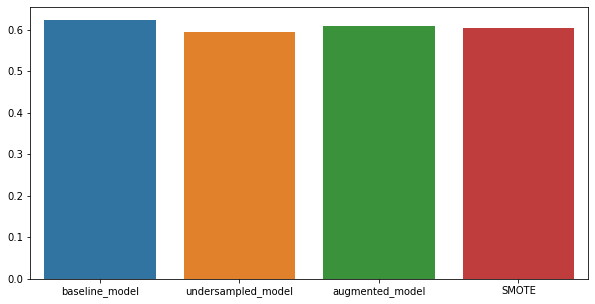

In [280]:
# plot graph to compare accuracy score

method_name = []
method_score = []
plt.figure(figsize=(10,5))
for method in imbalanced_dict.keys():
    method_name.append(method)
    method_score.append(imbalanced_dict[method]['accuracy'])
sns.barplot(method_name, method_score)

plt.show()


Unfortunately, the methodologies did not yield a better performance than the baseline model. Therefore, none of these methods will be applied in the final pipeline

## Final Preprocessing Pipeline

A final preprocessing pipeline was defined. This pipeline will be used to process the original Yahoo Answers 
dataset into a cleaner version.

In [4]:
# Pipeline

## Load data
data = pd.read_csv('rr_personalisation.csv', header=None)
data.columns = ['y1', 'y2', 'y3', 'text']

## Apply labelencoder to y values to normamlize them
le = LabelEncoder()
data['y1'] = le.fit_transform(data['y1'])
data['y2'] = le.fit_transform(data['y2'])
data['y3'] = le.fit_transform(data['y3'])

# creating category labels for labelling purposes
category_labels = {0: 'Society & Culture', 1: 'Science & Mathematics', 2: 'Health', 3: 'Education & Reference',
                    4: 'Computers & Internet', 5: 'Sports', 6: 'Business & Finance', 7: 'Entertainment & Music',
                    8: 'Family & Relationships', 9: 'Politics & Government'}

## Remove foreign questions

data['language'] = data['text'].apply(lambda x: [r[0] for r in cld2.detect(x)[2]])
data = data[data['language'].apply(lambda x: 'ENGLISH' in x) == True]
data.drop(columns=['language'], inplace=True)

## Remove duplicated values
data = data.drop_duplicates(subset='text', keep=False)

## Expand contractions
# define the function to expand words
def expand_contractions(text):
    # creating an empty list
    expanded_words = []
    # iterate through each word in each sentence   
    for word in text.split():
        # using contractions.fix to expand the shortened words
        expanded_words.append(contractions.fix(word))
        text = " ".join(expanded_words)    
    return text  

# apply the expand function
data['expanded'] = data['text'].apply(lambda row:expand_contractions(row))


## Lowercase
data['lowercased'] = data['expanded'].apply(lambda row: row.lower()) # iterate through each row of data frame

## Remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation]) # iterate through each letter and remove punctuation, then join letters as a sentence
    return punctuationfree

# storing the puntuation free text
data['punctuation_free'] = data['lowercased'].apply(lambda row:remove_punctuation(row))

## Handle sticky words
# data['words'] = [len(x.split()) for x in data['punctuation_free']]
data['no_sticky'] = data['punctuation_free'].apply(lambda row: ' '.join([word for word in wordninja.split(row)]))


## Decide minimum and maximum word length
# set parameter to minimum number of words in a review
min_text_size = 3
max_text_size = 25

# count number of reviews with more than minimum number of words and less than maximum number of words
data['words_2'] = [len(x.split()) for x in data['no_sticky']]
data = data[(data['words_2'] >= min_text_size) & (data['words_2'] <= max_text_size)]

# The data variable is successfully cleaned

## Split into train and test sets
X_train, X_test, y_train_full, y_test_full = train_test_split(data['no_sticky'],
                                                                            data[['y1', 'y2', 'y3']],
                                                                            test_size=0.1, # dedicate 10% of samples to test set
                                                                            random_state=66) # random state for reproducibility
y_train = y_train_full['y1'].to_numpy()
y_test = y_test_full['y1'].to_numpy()

## Tfidf 
tfidf = TfidfVectorizer(sublinear_tf=True, 
                            min_df=5,  # frequency of words in the corpus  
                            norm='l2', 
                            encoding='latin-1', 
                            ngram_range=(1, 2)) # 1-gram and 2-grams since we are dealing with short texts
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


# value created for training: X_train_tfidf, X_test_tfidf, y_train, y_test


## Evaluation Metric

An evaluation metric will have to be created, as we are assessing how well a model predicts three categories. A metric was designed to help assess these criterias:
1. Whether the true label is the first category prediction
2. Whether the true label is present in the top three predictions
3. Whether the 2nd or 3rd category appears in the predictions

In [5]:
## Baseline model

# Use train_test_split to split training data into training and validation sets
X_train, X_test, y_train_full, y_test_full = train_test_split(data["text"].to_numpy(),
                                                                           data[['y1', 'y2', 'y3']],
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=66) # random state for reproducibility

y_train = y_train_full['y1'].to_numpy()
y_test = y_test_full['y1']

# create vector form of text
tfidf = TfidfVectorizer(stop_words='english', min_df = 2, token_pattern=r'\b[^\d\W_]+\b')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


# create a logistic regression model
nb_best = MultinomialNB(alpha=0.1)
start = time.time()

nb_best.fit(X_train_tfidf, y_train)
stop = time.time()
nb_time = stop - start
# predict on test set
y_pred_prob = nb_best.predict_proba(X_test_tfidf)
y_pred = nb_best.predict(X_test_tfidf)

The evaluation function works by creating columns based on how well the prediction was performed on each 
question. The final metric that were used for model evaluation is the `eval_score`, which is an average 
score of all predictions

In [6]:
def showcase_evaluation_df(y_pred, y_true, x_true):
    """
    We want to get a table that contains y1, y2, y3, and its prediction probabilities
    
    """    
    y_label_probabilities_overall= []
    for i, question in enumerate(y_pred):
        y_label_probabilities_question = []
    
        y_label_probabilities_question.append(question[y_true.iloc[i][0]])
        y_label_probabilities_question.append(question[y_true.iloc[i][1]])
        y_label_probabilities_question.append(question[y_true.iloc[i][2]])

        y_label_probabilities_question.append(np.flip(question.argsort(axis=0))[0])
        y_label_probabilities_question.append(np.flip(question.argsort(axis=0))[1])
        y_label_probabilities_question.append(np.flip(question.argsort(axis=0))[2])

        y_label_probabilities_overall.append(y_label_probabilities_question)
    
    y_true = y_true.reset_index(drop=True)

    probability_df = pd.DataFrame(y_label_probabilities_overall, columns = ["label_1_prob", "label_2_prob", "label_3_prob", "label_1_pred", "label_2_pred", "label_3_pred"])
    prediction_df = pd.concat([y_true, probability_df], axis=1)

    # add question (x_true) to prediction_df
    prediction_df["question"] = x_true

    first_column = prediction_df.pop("question")
    prediction_df.insert(0, "question", first_column)

    # create new column where it checks to see whether label is in prediction 1, 2 and 3
    prediction_df["compare_y1"] = np.where(prediction_df["y1"] == prediction_df["label_1_pred"], "1", np.where(prediction_df["y1"] == prediction_df["label_2_pred"], "2", 
                            np.where(prediction_df["y1"] == prediction_df["label_3_pred"], "3", "0")))
    prediction_df["compare_y2"] = np.where(prediction_df["y2"] == prediction_df["label_1_pred"], "1", np.where(prediction_df["y2"] == prediction_df["label_2_pred"], "2",
                            np.where(prediction_df["y2"] == prediction_df["label_3_pred"], "3", "0")))
    prediction_df["compare_y3"] = np.where(prediction_df["y3"] == prediction_df["label_1_pred"], "1", np.where(prediction_df["y3"] == prediction_df["label_2_pred"], "2",
                            np.where(prediction_df["y3"] == prediction_df["label_3_pred"], "3", "0")))

    prediction_df["eval_y1"] = np.where(prediction_df["compare_y1"] == "1", 0.7, np.where(prediction_df["compare_y1"] == "2", 0.35, np.where(prediction_df["compare_y1"] == "3", 0.35, 0)))
    prediction_df["eval_y2"] = np.where(prediction_df["compare_y2"] == "2", 0.2, np.where(prediction_df["compare_y2"] == "1", 0.1, np.where(prediction_df["compare_y2"] == "3", 0.1, 0)))
    prediction_df["eval_y3"] = np.where(prediction_df["compare_y3"] == "3", 0.1, np.where(prediction_df["compare_y3"] == "1", 0.05, np.where(prediction_df["compare_y3"] == "2", 0.05, 0)))
    prediction_df['eval_score'] = (prediction_df["eval_y1"] + prediction_df["eval_y2"] + prediction_df["eval_y3"])


    return prediction_df

In [7]:
showcase_df = showcase_evaluation_df(y_pred_prob, y_test_full, X_test)

In [8]:
showcase_df.head(1).T

,0
question,"What Does Mutya Buena (ex-Sugababes),apl.de.ap..."
y1,7
y2,8
y3,0
label_1_prob,0.853146
label_2_prob,0.007135
label_3_prob,0.00633
label_1_pred,7
label_2_pred,6
label_3_pred,1


The table below explains the meaning for each column. 

| Column       |                                                                                           |
|--------------|-------------------------------------------------------------------------------------------|
| label_n_prob | The probability of Category $n$. This is generated by the function predict_proba          |
| label_n_pred | The label of `label_n_prob` ($\hat{y}$)                                                     |
| compare_y1   | The position of $y1$ in the prediction. 1 = y$\hat{y1}$, 2 = y$\hat{y2}$, 3 = y$\hat{y3}$ |
| compare_y2   | The position of $y2$ in the prediction. 1 = y$\hat{y1}$, 2 = y$\hat{y2}$, 3 = y$\hat{y3}$ |
| compare_y3   | The position of $y3$ in the prediction. 1 = y$\hat{y1}$, 2 = y$\hat{y2}$, 3 = y$\hat{y3}$ |
| eval_y1      | Score for $\hat{y1}$ (weight = 0.7)                                                      |
| eval_y2      | Score for $\hat{y2}$ (weight = 0.2)                                                      |
| eval_y3      | Score for $\hat{y3}$ (weight = 0.1)                                                      |
| eval_score   | The average between `eval_y1`, `eval_y2` and `eval_y3`                                      |

Below we can observe how the evaluation scores are distributed in this demo model. 

In [9]:
# Check distribution of eval_score
showcase_df['eval_score'].value_counts().sort_index(ascending=False)

1.00     348
0.90    2042
0.85     312
0.80    3988
0.75    2013
0.70    9587
0.60      50
0.55     220
0.55      61
0.50     102
0.45    1824
0.40     971
0.35    4986
0.30      52
0.25      47
0.20     357
0.15     158
0.10     867
0.05     530
0.00    1554
Name: eval_score, dtype: int64

### Showcase the breakdown of evaluation score range

The breakdown of score will use the compare_y columns created. compare_y1, compare_y2 and compare_y3 signifies the 
position of the true labels. The right predictions are made if compare_y1, compare_y2 and compare_y3 are 1, 2 and 
3 respectively.

| Score      | Meaning                                         |
|------------|-------------------------------------------------|
| 1          | All score is predicted                          |
| 0.7-0.9    | $y1$ is in $\hat{y1}$                           |
| 0.35-0.6   | $y1$ is in top 3                                  |
| 0.15- 0.30 | $y1$ is absent, but $y2$ and/or $y3$ is in prediction |
| 0          | None of y category is in $\hat{y}$              |

The following breakdown is as followss

#### Grade 1: The three $\hat{y}$ contains all three true $y1$ categories

In [694]:
# find rows where compare_y1, y2 and y3 is 1
grade1_showcase = showcase_df[(showcase_df['compare_y1'] == "1") & (showcase_df['compare_y2'] == "2") & (showcase_df['compare_y3'] == "3")]

In [698]:
grade1_showcase['eval_score'].value_counts()

1.0    286
Name: eval_score, dtype: int64

Evaluation score is 1 when all predictions aree correct

#### Grade 1: $\hat{y1}$ contains the true $y1$ category

For the Grade 1, compare_y1 == "1" is to filter our questions where the first true label is in $\hat{y1}$ while one of
 $\hat{y2}$ and $\hat{y3}$ is wrong

In [704]:
# find rows where compare_y1 is 1
grade2_showcase_draft = showcase_df[(showcase_df['compare_y1'] == "1")]

In [709]:
# filter out rows where commpare_y2 is not 2 or compare_y3 is not 3
grade2_showcase = grade2_showcase_draft[(grade2_showcase_draft['compare_y2'] != "2") | (grade2_showcase_draft['compare_y3'] != "3")]

In [710]:
grade2_showcase['eval_score'].value_counts()

0.70    9718
0.80    3962
0.90    2051
0.75    1999
0.85     331
Name: eval_score, dtype: int64

For all the questions that predicted the right true label (y1), evaluation score is 0.7 or more

#### Grade 3: True $y1$ category is in either $\hat{y2}$ or $\hat{y3}$

For the Grade 3, compare_y1 != "0" to filter out questions where the first true label is in either
$\hat{y2}$ or $\hat{y3}$

In [711]:
# filter where compare_y1 is 2 AND 3
grade3_showcase = showcase_df[(showcase_df['compare_y1'] == "2") | (showcase_df['compare_y1'] == "3")]


In [712]:
grade3_showcase['eval_score'].value_counts()

0.35    4829
0.45    1770
0.40    1016
0.55     217
0.50      94
0.55      76
0.60      35
Name: eval_score, dtype: int64

#### Grade 4: $y1$ category is absent in $\hat{y}$, but $y2$ category and/or $y3$ is predicted

In [714]:
# fiilter where compare_y1 is "0", but compare_y2 and compare_y3 is not "0"
grade4_showcase = showcase_df[(showcase_df['compare_y1'] == "0") & (showcase_df['compare_y2'] != "0") & (showcase_df['compare_y3'] != "0")]

In [715]:
grade4_showcase['eval_score'].value_counts()

0.15    147
0.25     61
0.20     53
0.30     45
Name: eval_score, dtype: int64

#### Grade 5: None of $y$ category is in $\hat{y}$

In [716]:
# filter where compare_y1, y2 and y3 is "0"
grade5_showcase = showcase_df[(showcase_df['compare_y1'] == "0") & (showcase_df['compare_y2'] == "0") & (showcase_df['compare_y3'] == "0")]

In [717]:
grade5_showcase['eval_score'].value_counts()

0.0    1518
Name: eval_score, dtype: int64

## Functions

These functions are designed to help train models, evaluate it with the metric designed above, and store them into dictionaries as storagee

In [38]:
def add_model_results(model_dict, model_name, accuracy_score, training_time, eval_present_weighted, data_size):
    model_dict[model_name] = {'accuracy': accuracy_score,'training_time': training_time, 'eval_present_weighted': eval_present_weighted, 'data_size': data_size}
    return model_dict

In [39]:
def create_evaluation(y_pred, y_true, x_true):
    """
    We want to get a table that contains y1, y2, y3, and its prediction probabilities
    
    """    
    y_label_probabilities_overall= []
    for i, question in enumerate(y_pred):
        y_label_probabilities_question = []
    
        y_label_probabilities_question.append(question[y_true.iloc[i][0]])
        y_label_probabilities_question.append(question[y_true.iloc[i][1]])
        y_label_probabilities_question.append(question[y_true.iloc[i][2]])

        y_label_probabilities_question.append(np.flip(question.argsort(axis=0))[0])
        y_label_probabilities_question.append(np.flip(question.argsort(axis=0))[1])
        y_label_probabilities_question.append(np.flip(question.argsort(axis=0))[2])

        y_label_probabilities_overall.append(y_label_probabilities_question)
    
    y_true = y_true.reset_index(drop=True)

    probability_df = pd.DataFrame(y_label_probabilities_overall, columns = ["label_1_prob", "label_2_prob", "label_3_prob", "label_1_pred", "label_2_pred", "label_3_pred"])
    prediction_df = pd.concat([y_true, probability_df], axis=1)

    # add question (x_true) to prediction_df
    prediction_df["question"] = x_true

    first_column = prediction_df.pop("question")
    prediction_df.insert(0, "question", first_column)

    # create new column where it checks to see whether label is in prediction 1, 2 and 3
    prediction_df["compare_y1"] = np.where(prediction_df["y1"] == prediction_df["label_1_pred"], "1", np.where(prediction_df["y1"] == prediction_df["label_2_pred"], "2", 
                            np.where(prediction_df["y1"] == prediction_df["label_3_pred"], "3", "0")))
    prediction_df["compare_y2"] = np.where(prediction_df["y2"] == prediction_df["label_1_pred"], "1", np.where(prediction_df["y2"] == prediction_df["label_2_pred"], "2",
                            np.where(prediction_df["y2"] == prediction_df["label_3_pred"], "3", "0")))
    prediction_df["compare_y3"] = np.where(prediction_df["y3"] == prediction_df["label_1_pred"], "1", np.where(prediction_df["y3"] == prediction_df["label_2_pred"], "2",
                            np.where(prediction_df["y3"] == prediction_df["label_3_pred"], "3", "0")))

    prediction_df["eval_y1"] = np.where(prediction_df["compare_y1"] == "1", 2.1, np.where(prediction_df["compare_y1"] == "2", 1.15, np.where(prediction_df["compare_y1"] == "3", 1.15, 0)))
    prediction_df["eval_y2"] = np.where(prediction_df["compare_y2"] == "2", 0.6, np.where(prediction_df["compare_y2"] == "1", 0.3, np.where(prediction_df["compare_y1"] == "3", 0.3, 0)))
    prediction_df["eval_y3"] = np.where(prediction_df["compare_y3"] == "3", 0.3, np.where(prediction_df["compare_y3"] == "1", 0.15, np.where(prediction_df["compare_y1"] == "2", 0.15, 0)))
    prediction_df['eval_score'] = (prediction_df["eval_y1"] + prediction_df["eval_y2"] + prediction_df["eval_y3"])/3
    
    # mean of eval_score
    eval_present_weighted = prediction_df["eval_score"].mean()

    # return evaluation score
    return eval_present_weighted

# 3. Model Comparison

Three important metrics are captured and stored into a dictionary. This is the following:
1. Training Time
2. Evaluation Score
3. Sample Size

In [39]:
model_dict = {}

## Logistic Regression

A function `test_model` was created to be able to train the model while storing the key metrics into a 
dictionary

In [43]:
def test_model(model, model_name, dict):
    start = time.time()

    model.fit(X_train_tfidf, y_train)
    stop = time.time()
    model_time = stop - start
    print("Model fitting time for: {}".format(model_time))


    # predict on test set
    y_pred = model.predict(X_test_tfidf)
    print("Accuracy for model: {}".format((model.score(X_test_tfidf, y_test)*100)))
    

    # create prediction score
    eval_present_weighted =  create_evaluation(model.predict_proba(X_test_tfidf), y_test_full, X_test)
    print("Evaluation score for model: {}".format((eval_present_weighted)*100))
    dict = add_model_results(dict, model_name, model.score(X_test_tfidf, y_test), model_time, eval_present_weighted, data_size=len(X_train))
    return dict

The first model, Logistic Regression, was trained. 

In [44]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=66)
model_dict = test_model(logreg, "logreg", model_dict)

Model fitting time for: 72.85908198356628
Accuracy for model: 62.326648707971664
Evaluation score for model: 59.03854468056804


## Random Forest

Random Forest (RF) is the 2nd model. RF contains a lot of drawback for this research, as it took 
the longest to train (fitting time = > 35 minutes)

In [45]:
rf = RandomForestClassifier(random_state=66)
model_dict = test_model(rf, "Random Forest", model_dict)

Model fitting time for: 2204.3541181087494
Accuracy for model: 50.99604243573115
Evaluation score for model: 52.70610928198478


## Naive Bayes 

Multinomial Naive Bayes was the third model fitted. This model took the fastest time, as well as scoring 
fairly well in the prediction

In [46]:
nb_best = MultinomialNB(alpha=0.1)
model_dict = test_model(nb_best, "Naive Bayes", model_dict)


Model fitting time for: 0.20862174034118652
Accuracy for model: 61.239149955103265
Evaluation score for model: 58.235724500315946


## Gradient Boosting

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

Gradient Boosting classifier was also used as the fourth model. However, this model showed poor performance, 
as well as taking a long time to train

In [49]:
gradient_boost = GradientBoostingClassifier(random_state=66)
model_dict = test_model(gradient_boost,'GradientBoosting', model_dict)


Model fitting time for: 1231.9987697601318
Accuracy for model: 48.25567860587316
Evaluation score for model: 50.12449144744865


## Support Vector Machine

Support Vector Machine (SVM) has shown good performances in many instances, but is very computationally 
intensive. A test run was halted as a SVM model with a full dataset ran for more than 8 hours. To 
create a score for comparison purpose, a SVM model was fitted with only 30% of the sample size

* will be using 30% as a comparison score

In [71]:
def test_sample_size_svm(df, sample_size_test, dict):
    for sample_size in sample_size_test:
        print("Testing out sample size of {}%".format(int(sample_size*100)))
        if sample_size == 1:
            df_sample = df
        else:
            df_sample = df.sample(frac=sample_size, random_state=12)

        data_size = len(df_sample)

        # train_test split
        X_train, X_test, y_train_full, y_test_full = train_test_split(df_sample['text'], df_sample[['y1', 'y2', 'y3']], test_size=0.1, random_state=12)

        y_train = y_train_full['y1'].to_numpy()
        y_test = y_test_full['y1'].to_numpy()


        # create vector form of text
        tfidf = TfidfVectorizer(sublinear_tf=True, 
                            min_df=5,  # frequency of words in the corpus  
                            norm='l2', 
                            encoding='latin-1', 
                            ngram_range=(1, 2)) # 1-gram and 2-grams since we are dealing with short texts
        X_train_tfidf = tfidf.fit_transform(X_train)
        X_test_tfidf = tfidf.transform(X_test)

        

        # create a random forest model
        svm_model = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability=True)
        start = time.time()

        svm_model.fit(X_train_tfidf, y_train)
        stop = time.time()
        svm_time = stop - start

        # predict on test set
        y_pred = svm_model.predict(X_test_tfidf)
 
        print("Accuracy for {}% sample size: {}".format(int(sample_size*100), (svm_model.score(X_test_tfidf, y_test)*100)))


        # create prediction score
        eval_present_weighted =  create_evaluation(svm_model.predict_proba(X_test_tfidf), y_test_full, X_test)
        print("Evaluation score for model: {}".format((eval_present_weighted)*100))
        print("\n")

        dict = add_model_results(dict, "SVM" + (str(int(sample_size*100))+"%"), svm_model.score(X_test_tfidf, y_test), svm_time, eval_present_weighted, data_size)
    
    return dict

Even with a 30% sample size, the SVM model took 75 minutes to run

In [72]:
model_dict = test_sample_size_svm(data, [0.3], model_dict)

Testing out sample size of 30%
Accuracy for 30% sample size: 58.8072275800909
Evaluation score for model: 57.13076894653217




## LSTM Model

A LSTM network was built to test its performance on text classification. However, due to its nature, a different 
preprocessing methodology is required to set up. TensorFlow will be used to buiid the LSTM model

### Split into Test and Train

In [51]:
## Split into train and test
# subset data with only y1, y2 and y3
data_subset = data[['y1', 'y2', 'y3']]


# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels_full, val_labels_full = train_test_split(data["no_sticky"].to_numpy(),
                                                                           data[['y1', 'y2', 'y3']],
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=66) # random state for reproducibility
train_labels = train_labels_full['y1'].to_numpy()
val_labels = val_labels_full['y1'].to_numpy()

# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(270618, 270618, 30069, 30069)

### Create text vectorizer

While other machine learning models utilise the `TFIDFVectorizer` function, the LSTM model will use 
TensorFlow's `TextVectorizer` function to create a text preprocessing layer in the network

/opt/anaconda3/envs/nlp_clone/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

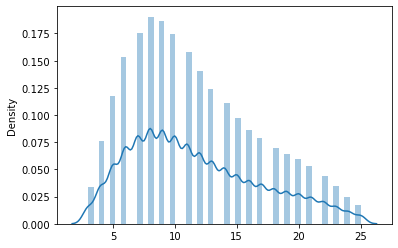

In [52]:
# Find average number of tokens (words) in training
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
len_list = []

for q in train_sentences:
    len_list.append(len(q.split()))
# plot distribution of len_list
import seaborn as sns
sns.distplot(len_list)



A graph was plotted to see the word length distribution of the training dataset. As a result, a max length of 25 
was set for our vocabulary

In [53]:
# Setup text vectorization with custom variables
max_vocab_length = 50000 
# max number of words to have in our vocabulary
max_length = 25
 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

2022-08-28 16:32:39.170121: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The `adapt` function will create the word embedding structure from our training dataset

In [54]:
text_vectorizer.adapt(train_sentences)


### Train model

In [55]:
tf.keras.backend.clear_session()

The embedding layer was defined

In [56]:
embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")

The whole LSTM network was constructed. The LSTM model contains the following architecture:
1. A text vectorisation layer that converts the text into a numerical sequence
2. An embedding layeerr
3. A LSTM layer with a memory unit of 128
4. An output layer with a softmax activation function

In [57]:
# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(128)(x) # return vector for whole sequence
outputs = layers.Dense(10, activation="softmax")(x)
model_LSTM = tf.keras.Model(inputs, outputs, name="model_LSTM")

In [58]:
# Compile model
model_LSTM.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_LSTM.summary()


Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 25)               0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 25, 128)           6400000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 6,532,874
Trainable params: 6,532,874
Non-trainable params: 0
______________________________________________

Model was fitted. Although model took 7 minutes, it performed really well

In [59]:
# Fit model
start = time.time()
model_LSTM_history = model_LSTM.fit(train_sentences,
                              train_labels,
                              epochs=2,
                              validation_data=(val_sentences, val_labels)
                              )
stop = time.time()
LSTM_time = stop - start

Epoch 1/2
8457/8457 [==============================] - 208s 24ms/step - loss: 1.2894 - accuracy: 0.5648 - val_loss: 1.1016 - val_accuracy: 0.6263
Epoch 2/2
8457/8457 [==============================] - 215s 25ms/step - loss: 0.9758 - accuracy: 0.6688 - val_loss: 1.0790 - val_accuracy: 0.6349


### Finding evaluation scores

To find the evaluation score for the LSTM model, an evaluation function will have to be created for it

Firstly, the accuracy score was recorded as a benchmark

In [60]:
lstm_accuracy = model_LSTM_history.history["val_accuracy"][-1]

The class probability that the LSTM model predicted for each question was called using the `predict` function

In [61]:
lstm_pred = model_LSTM.predict(val_sentences)

In [62]:
def evaluate_nn_model(y_pred, y_test, x_test):
    eval_present_weighted =  create_evaluation(y_pred, y_test, x_test)
    return eval_present_weighted

The evaluation score was obtained by defining the function as above

In [63]:
lstm_weighted_eval = evaluate_nn_model(lstm_pred, val_labels_full, val_sentences)

In [64]:
model_dict = add_model_results(model_dict, "LSTM", lstm_accuracy, LSTM_time, lstm_weighted_eval,len(train_sentences))

In [65]:
model_dict

{'logreg': {'accuracy': 0.6232664870797167,
  'training_time': 72.85908198356628,
  'eval_present_weighted': 0.5903854468056804,
  'data_size': 270618},
 'Random Forest': {'accuracy': 0.5099604243573115,
  'training_time': 2204.3541181087494,
  'eval_present_weighted': 0.5270610928198478,
  'data_size': 270618},
 'Naive Bayes': {'accuracy': 0.6123914995510327,
  'training_time': 0.20862174034118652,
  'eval_present_weighted': 0.5823572450031594,
  'data_size': 270618},
 'GradientBoosting': {'accuracy': 0.4825567860587316,
  'training_time': 1231.9987697601318,
  'eval_present_weighted': 0.5012449144744865,
  'data_size': 270618},
 'LSTM': {'accuracy': 0.6349064111709595,
  'training_time': 422.9429590702057,
  'eval_present_weighted': 0.5936928398017892,
  'data_size': 270618}}

## FastText

Like LSTM, FastText requires its own preprocessing methodology to prepare the dataset for training 
on their model

In [166]:
# # download "https://github.com/facebookresearch/fastText/archive/v0.9.2.zip" using wget
# wget.download("https://github.com/facebookresearch/fastText/archive/v0.9.2.zip")

# # install using pip install fasttext-0.9.2.zip

'fastText-0.9.2.zip'

In [228]:
data_fast_text = data.copy()


FastText model requires the label to be formatted in a specific way. For instance, if the label is 7, the 
FastText must read it as '__label__7'

In [231]:
# add '__label__' to the beginning of each label
data_fast_text['fasttext'] = data_fast_text['y1'].apply(lambda x: '__label__' + str(x))

In [232]:
# Use train_test_split to split training data into training and validation sets
train, test = train_test_split(data_fast_text, test_size=0.1, random_state=66) 

The training and test text file requires to be converted to a .txt file for the model fitting

In [233]:
train[['fasttext', 'no_sticky']].to_csv(
    'train.txt', index = False, sep = ' ',header = None, quoting = csv.QUOTE_NONE, quotechar = "", escapechar = " ")

In [234]:
test[['fasttext', 'no_sticky']].to_csv(
    'test.txt', index = False, sep = ' ',header = None, quoting = csv.QUOTE_NONE, quotechar = "", escapechar = " ")

### Baseline FastText Model

The model was first fitted below, without defining any parameters. Even with a baseline model, the 
evaluation performance was great as well as it being very fast

In [235]:
start=time.time()
fasttext_model = fasttext.train_supervised(input='train.txt')
stop=time.time()
fasttext_time = stop-start
print("time taken to train = " + str(fasttext_time))
fasttext_model.test("test.txt")

Read 3M words
Number of words:  49775
Number of labels: 10
Progress:  89.2% words/sec/thread: 1511973 lr:  0.010755 avg.loss:  1.216226 ETA:   0h 0m 0s

time taken to train = 2.065330743789673


Progress: 100.0% words/sec/thread: 1497735 lr:  0.000000 avg.loss:  1.191116 ETA:   0h 0m 0s


(30069, 0.6206391965146829, 0.6206391965146829)

### Optimised FastText Model

After trying out the baseliine model, the FastText was optimised on the full dataset using FastText's optimisation function. The parameters that were given were added to the argument for the next model

In [16]:
start=time.time()
fasttext_bestmodel = fasttext.train_supervised(input='train.txt', lr = 0.5850485445266574, dim=438, ws=5, epoch=5, minCount=1, minCountLabel=0, minn=2, maxn=5, neg=5, wordNgrams=2, loss='softmax', bucket=4708810, thread=7, lrUpdateRate=100, t=0.0001,  verbose=2)
stop=time.time()
fasttext_time_best = stop-start
print("time taken to train = " + str(fasttext_time_best))
fasttext_bestmodel.test("test.txt")

Read 3M words
Number of words:  49775
Number of labels: 10
Progress: 100.0% words/sec/thread:   25366 lr:  0.000000 avg.loss:  1.174706 ETA:   0h 0m 0s 15.4% words/sec/thread:   29638 lr:  0.494741 avg.loss:  1.500723 ETA:   0h 1m15s 31.5% words/sec/thread:   27214 lr:  0.400523 avg.loss:  1.375138 ETA:   0h 1m 6s 36.5% words/sec/thread:   23529 lr:  0.371376 avg.loss:  1.354380 ETA:   0h 1m11s  25022 lr:  0.023853 avg.loss:  1.182089 ETA:   0h 0m 4s


time taken to train = 111.8398551940918


(30069, 0.6283547839968073, 0.6283547839968073)

### Calculate evaluation score for FastText models

The function below was created to calculate the evaluation score in the FastText model. The metric folllows the 
same algorithm as the previous one used.

In [236]:
def fasttext_evaluation(fasttext_model, test_data):

    test_text = test_data['no_sticky'].tolist()

    label_1_pred_list = []
    label_2_pred_list = []
    label_3_pred_list = []
    for question in test_text:
        fasttext_prediction = fasttext_model.predict(question, k=3)[0]
        # convert '__label__x' to 'x'
        fasttext_prediction1 = int(fasttext_prediction[0].split('__label__')[1])
        fasttext_prediction2 = int(fasttext_prediction[1].split('__label__')[1])
        fasttext_prediction3 = int(fasttext_prediction[2].split('__label__')[1])

        # add to list
        label_1_pred_list.append(fasttext_prediction1)
        label_2_pred_list.append(fasttext_prediction2)
        label_3_pred_list.append(fasttext_prediction3)
    test['label_1_pred'] = label_1_pred_list
    test['label_2_pred'] = label_2_pred_list
    test['label_3_pred'] = label_3_pred_list

    # create new column where it checks to see whether label is in prediction 1, 2 and 3
    test["compare_y1"] = np.where(test["y1"] == test["label_1_pred"], "1", np.where(test["y1"] == test["label_2_pred"], "2", 
                            np.where(test["y1"] == test["label_3_pred"], "3", "0")))
    test["compare_y2"] = np.where(test["y2"] == test["label_1_pred"], "1", np.where(test["y2"] == test["label_2_pred"], "2",
                            np.where(test["y2"] == test["label_3_pred"], "3", "0")))
    test["compare_y3"] = np.where(test["y3"] == test["label_1_pred"], "1", np.where(test["y3"] == test["label_2_pred"], "2",
                            np.where(test["y3"] == test["label_3_pred"], "3", "0")))

    # y1_present = (len(test) - len(test[test['compare_y1'] == "0"])) * 2.1
    # y2_present = (len(test) - len(test[test['compare_y2'] == "0"])) * 0.6
    # y3_present = (len(test) - len(test[test['compare_y3'] == "0"])) * 0.3

    # y_present = (y1_present + y2_present + y3_present)/3

    # eval_present_weighted_fasttext = y_present/len(test)

    test["eval_y1"] = np.where(test["compare_y1"] == "1", 2.1, np.where(test["compare_y1"] == "2", 1.15, np.where(test["compare_y1"] == "3", 1.15, 0)))
    test["eval_y2"] = np.where(test["compare_y2"] == "2", 0.6, np.where(test["compare_y2"] == "1", 0.3, np.where(test["compare_y2"] == "3", 0.3, 0)))
    test["eval_y3"] = np.where(test["compare_y3"] == "3", 0.3, np.where(test["compare_y3"] == "1", 0.15, np.where(test["compare_y3"] == "2", 0.15, 0)))
    test['eval_score'] = (test["eval_y1"] + test["eval_y2"] + test["eval_y3"])/3

    # mean of eval_score
    eval_present_weighted_fasttext = test["eval_score"].mean()

    # calculate accuracy
    fasttext_y_pred = test['label_1_pred'].tolist()
    fasttext_y_true = test['y1'].tolist()
    fasttext_accuracy = accuracy_score(fasttext_y_true, fasttext_y_pred)

    return eval_present_weighted_fasttext, fasttext_accuracy

In [22]:
# Calculate evaluation metrics
fasttext_base_eval, fasttext_base_accuracy = fasttext_evaluation(fasttext_model, test)
fasttext_best_eval, fasttext_best_accuracy = fasttext_evaluation(fasttext_bestmodel, test)

The evaluation score for both baseline and optimised models were stored for FastText models

In [68]:
# Add FastText evaluattion metrics to model_dict
model_dict = add_model_results(model_dict, "FastText - Base", fasttext_base_accuracy, time1, fasttext_base_eval,len(train))
model_dict = add_model_results(model_dict, "FastText - Optimised", fasttext_best_accuracy, fasttext_time_best, fasttext_best_eval,len(train))

Currently, we have results from 7 models stored in the dictionary file

In [70]:
model_dict

{'logreg': {'accuracy': 0.6232664870797167,
  'training_time': 72.85908198356628,
  'eval_present_weighted': 0.5903854468056804,
  'data_size': 270618},
 'Random Forest': {'accuracy': 0.5099604243573115,
  'training_time': 2204.3541181087494,
  'eval_present_weighted': 0.5270610928198478,
  'data_size': 270618},
 'Naive Bayes': {'accuracy': 0.6123914995510327,
  'training_time': 0.20862174034118652,
  'eval_present_weighted': 0.5823572450031594,
  'data_size': 270618},
 'GradientBoosting': {'accuracy': 0.4825567860587316,
  'training_time': 1231.9987697601318,
  'eval_present_weighted': 0.5012449144744865,
  'data_size': 270618},
 'LSTM': {'accuracy': 0.6349064111709595,
  'training_time': 422.9429590702057,
  'eval_present_weighted': 0.5936928398017892,
  'data_size': 270618},
 'FastText - Base': {'accuracy': 0.6197080049220127,
  'training_time': 27.149047136306763,
  'eval_present_weighted': 0.586951123526999,
  'data_size': 270618},
 'FastText - Optimised': {'accuracy': 0.628354783

### Look through results of FastText

Here, we want to showcase the model performance of the FastText model

In [237]:
test_text = test['no_sticky'].tolist()

label_1_pred_list = []
label_2_pred_list = []
label_3_pred_list = []
for question in test_text:
    fasttext_prediction = fasttext_model.predict(question, k=3)[0]
    # convert '__label__x' to 'x'
    fasttext_prediction1 = int(fasttext_prediction[0].split('__label__')[1])
    fasttext_prediction2 = int(fasttext_prediction[1].split('__label__')[1])
    fasttext_prediction3 = int(fasttext_prediction[2].split('__label__')[1])

    # add to list
    label_1_pred_list.append(fasttext_prediction1)
    label_2_pred_list.append(fasttext_prediction2)
    label_3_pred_list.append(fasttext_prediction3)
test['label_1_pred'] = label_1_pred_list
test['label_2_pred'] = label_2_pred_list
test['label_3_pred'] = label_3_pred_list

# create new column where it checks to see whether label is in prediction 1, 2 and 3
test["compare_y1"] = np.where(test["y1"] == test["label_1_pred"], "1", np.where(test["y1"] == test["label_2_pred"], "2", 
                        np.where(test["y1"] == test["label_3_pred"], "3", "0")))
test["compare_y2"] = np.where(test["y2"] == test["label_1_pred"], "1", np.where(test["y2"] == test["label_2_pred"], "2",
                        np.where(test["y2"] == test["label_3_pred"], "3", "0")))
test["compare_y3"] = np.where(test["y3"] == test["label_1_pred"], "1", np.where(test["y3"] == test["label_2_pred"], "2",
                        np.where(test["y3"] == test["label_3_pred"], "3", "0")))


test["eval_y1"] = np.where(test["compare_y1"] == "1", 2.1, np.where(test["compare_y1"] == "2", 1.15, np.where(test["compare_y1"] == "3", 1.15, 0)))
test["eval_y2"] = np.where(test["compare_y2"] == "2", 0.6, np.where(test["compare_y2"] == "1", 0.3, np.where(test["compare_y2"] == "3", 0.3, 0)))
test["eval_y3"] = np.where(test["compare_y3"] == "3", 0.3, np.where(test["compare_y3"] == "1", 0.15, np.where(test["compare_y3"] == "2", 0.15, 0)))
test['eval_score'] = (test["eval_y1"] + test["eval_y2"] + test["eval_y3"])/3

# mean of eval_score
eval_present_weighted_fasttext = test["eval_score"].mean()

# calculate accuracy
fasttext_y_pred = test['label_1_pred'].tolist()
fasttext_y_true = test['y1'].tolist()
fasttext_accuracy = accuracy_score(fasttext_y_true, fasttext_y_pred)

#### FastText: Scoring Breakdown

To further analyse the evaluation score, we want to look into the % of the following:
- % of questions that has the first category in the first prediction
- % of questions that has first category in the top 3 prediction

We can find the following:
1. 62.1% of the questions had $y1$ predicted on $\hat{y1}$
2. 88.8% of the questions had $y1$ predicted on either $\hat{y1}$, $\hat{y2}$ or $\hat{y3}$
3. On the other hand, 11.2% of the questions do not have $y1$ in the predictions

In [378]:
# % of questions that has first category in first prediction

len(test[test['eval_score'] >= 0.7])/(len(test))

0.6206391965146829

In [379]:
# % of questions that has first category in top 3 categories

# len(test[test['eval_score'] >= 0.4])/(len(test))
len(test[test['eval_y1'] != 0])/len(test)

0.8879576972962187

In [388]:
# percentage of questions that do not have first category in top 3 categories
len(test[test['eval_y1'] == 0])/len(test)

0.11204230270378131

#### FastText: Wrong Prediction Analysiis

Here, we will look at instances where the first category were not present in the top 3 predictions

In [389]:
y1_absence = test[test['eval_y1'] == 0]

In [391]:
y1_absence[['y1', 'y2', 'y3', 'label_1_pred', 'label_2_pred', 'label_3_pred']]

,y1,y2,y3,label_1_pred,label_2_pred,label_3_pred
162025,1,6,4,2,6,8
38421,5,9,0,6,4,7
81877,0,9,5,6,1,2
235957,9,8,3,7,6,3
86100,9,8,0,3,6,0
...,...,...,...,...,...,...
96219,2,6,1,6,7,0
86971,5,0,3,1,6,3
285853,6,1,2,9,0,3
248484,0,3,8,1,2,3


Very interestingly, most of the predictions that do not have y1 in the top 3 prediction are made by Category 6, which 
pertains to Business & Finance

In [760]:
# observe the distribution of incorrect 1st prediction

y1_absence_vc = y1_absence['label_1_pred'].value_counts()
y1_absence_vc.rename(index=category_labels)

Business & Finance        1544
Education & Reference      325
Science & Mathematics      320
Health                     258
Family & Relationships     185
Politics & Government      184
Computers & Internet       152
Society & Culture          145
Entertainment & Music      138
Sports                     118
Name: label_1_pred, dtype: int64

## Model Comparison

### Plot comparison graphs

To perform comparison, the dictionary file is converted into a dataframe. This will allow an easier 
visualisation of the model performance

In [46]:
# convert model_dict to dataframe
model_dict_df = pd.DataFrame.from_dict(model_dict, orient='index')

In [47]:
# change name of eval_present_weighted to EvaluationScore
model_dict_df.rename(columns={'eval_present_weighted': 'EvaluationScore'}, inplace=True)

In [54]:
# rename SVM30% index
model_dict_df.rename(index={'SVM30%': 'SVM (30%)'}, inplace=True)

In [56]:
model_dict_df

,accuracy,training_time,EvaluationScore,data_size
logreg,0.623266,72.859082,0.590385,270618
Random Forest,0.509960,2204.354118,0.527061,270618
Naive Bayes,0.612391,0.208622,0.582357,270618
GradientBoosting,0.482557,1231.998770,0.501245,270618
LSTM,0.634906,422.942959,0.593693,270618
FastText - Base,0.619708,27.149047,0.586951,270618
FastText - Optimised,0.628355,111.839855,0.591264,270618
SVM 30%,0.588072,4518.414807,0.571308,90206


A new column `accuracy/training_time` was created to gain a metric that takes into account both evaluation score 
and training time

In [101]:
model_dict_df['accuracy/training_time'] = model_dict_df['accuracy']/model_dict_df['training_time']

In [719]:
# Create a function that will draw a bar chart of the model results

def plot_bar_chart(df, category):
    model_name = []
    accuracy = []
    # generate colour #TODO
    colour = [] #TODO
    for model in df.index:
        model_name.append(model)
        accuracy.append(df.loc[model][category])
    plt.figure(figsize=(10, 5))
    plt.bar(model_name, accuracy)
    plt.xlabel('Model')
    plt.ylabel(str(category))
    plt.xticks(rotation=45)

    
    if category != "training_time" and category != "data_size" and category!= "accuracy/training_time":
        plt.ylim(0, 0.7)
    
    else: pass
    
    # add bar chart value to graph
    for i, v in enumerate(accuracy):
        plt.text(i, v, str(round(v, 3)), position=(i, v), ha="center", va="bottom", fontweight='bold')
    
    # position text at the top of the bar
    

    plt.show()

#### Evaluation Score Chart

The chart shows that LSTM performed the best, followed by FastText (optimised), Logistic Regression, 
FastText (baseline) and Naive Bayes

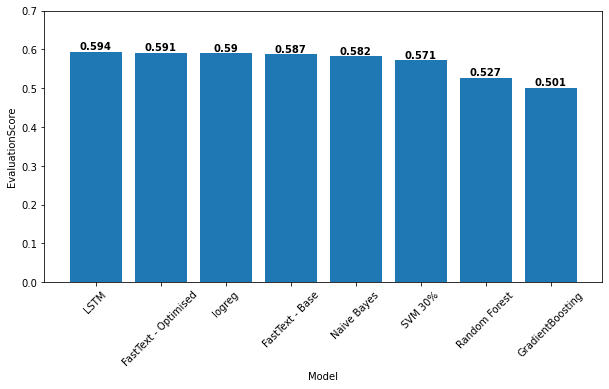

In [720]:
plot_bar_chart(model_dict_df.sort_values(by=['EvaluationScore'], ascending=False), "EvaluationScore")

#### Training Time Chart

Naive Bayes took the shortest time to train (0.2 seconds), followed by FastText Baseline (27 seconds) and Logistic 
Regression (72 seconds)

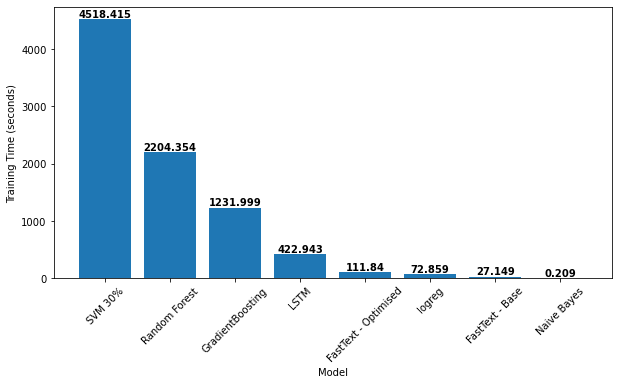

In [725]:
plot_bar_chart(model_dict_df.sort_values(by=['training_time'], ascending=False), "training_time")

In [112]:
# Create a function that will draw a bar chart of the model results in log scale

def plot_bar_chart_log(df, category):
    model_name = []
    accuracy = []
    # generate colour #TODO
    colour = [] #TODO
    for model in df.index:
        model_name.append(model)
        accuracy.append(df.loc[model][category])
    plt.figure(figsize=(10, 5))
    plt.bar(model_name, accuracy)
    plt.xlabel('Model')
    plt.ylabel(str(category))
    plt.title('Model ' + str(category))
    plt.xticks(rotation=45)
    # log y axis
    plt.yscale('log')
    
    if category != "training_time" and category != "data_size" and category!= "accuracy/training_time":
        plt.ylim(0, 0.7)
    
    else: pass

    plt.show()

#### Score/Time Chart

Taking both score and time into consideration, Naive Bayes performed the best, followed by FastText (baseline) and 
Logistic Regression

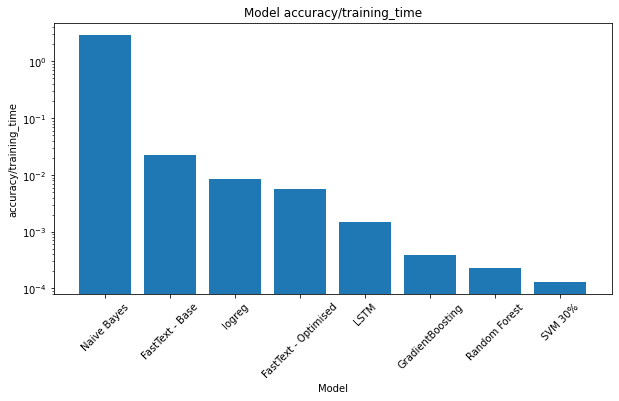

In [113]:
plot_bar_chart_log(model_dict_df.sort_values(by=['accuracy/training_time'], ascending=False), 'accuracy/training_time')

In [98]:
# add adjust_text to plot_model_performance function
def plot_model_performance(df):
    plt.figure(figsize=(10,7))
    ax1 = plt.subplot(1,1,1)
    text = []
    for model in df.index:
        ax1.scatter(df.loc[model]["training_time"], df.loc[model]["EvaluationScore"], label=model)

    plt.xlabel('Training Time (s)')
    plt.ylabel('Evaluation Score')
    plt.title('Model Performance')
    # add label to each point
    for i, txt in enumerate(text):
        ax1.annotate(txt, (df.loc[txt]["training_time"], df.loc[txt]["EvaluationScore"]))
        
    plt.legend()
    plt.show()

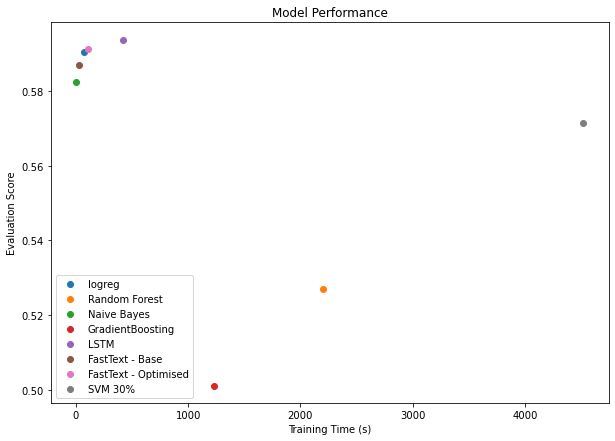

In [100]:
plot_model_performance(model_dict_df)

# 4. Data Sample Size Analysis

We are testing out three models

1. Logistic Regression
2. Multinomial Naive Bayes
3. FastText

This is because these three models performed the best in regards to both model performancee and training time. For each model, 
model were trained with 10 different training sizes (from 10% to 100%). 

The following relationships are analysed:
1. Sample Size vs Model Performance
2. Model Performance vs Training Time
3. Sample Size vs Training Time

In [40]:
def test_sample_size_model(df, model, sample_size_test, dict):
    for sample_size in sample_size_test:
        print("Testing out sample size of {}%".format(int(sample_size*100)))
        if sample_size == 1:
            df_sample = df
        else:
            df_sample = df.sample(frac=sample_size, random_state=12)

        data_size = len(df_sample)

        # train_test split
        X_train, X_test, y_train_full, y_test_full = train_test_split(df_sample['text'], df_sample[['y1', 'y2', 'y3']], test_size=0.1, random_state=12)

        y_train = y_train_full['y1'].to_numpy()
        y_test = y_test_full['y1'].to_numpy()


        # create vector form of text
        tfidf = TfidfVectorizer(stop_words='english', min_df = 2, token_pattern=r'\b[^\d\W_]+\b')
        X_train_tfidf = tfidf.fit_transform(X_train)
        X_test_tfidf = tfidf.transform(X_test)

        start = time.time()
        model.fit(X_train_tfidf, y_train)
        stop = time.time()
        fitting_time = stop - start

        # predict on test set
        y_pred = model.predict(X_test_tfidf)

        # create prediction score
        eval_present_weighted =  create_evaluation(model.predict_proba(X_test_tfidf), y_test_full, X_test)

        dict = add_model_results(dict, (str(int(sample_size*100))+"%"), model.score(X_test_tfidf, y_test), fitting_time, eval_present_weighted, data_size)
    return dict

In [41]:
# set the sample size that will be used to test
sample_size = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

### LogReg Sample Size

Firstly, the Logistic Regression model was tested on 10 different training size

In [42]:
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=66)
logreg_sample_dict = {}
logreg_sample_dict = test_sample_size_model(data, log_reg, sample_size, logreg_sample_dict)

Testing out sample size of 10%
Testing out sample size of 20%
Testing out sample size of 30%
Testing out sample size of 40%
Testing out sample size of 50%
Testing out sample size of 60%
Testing out sample size of 70%
Testing out sample size of 80%
Testing out sample size of 90%
Testing out sample size of 100%


In [126]:
logreg_sample_dict_df = pd.DataFrame.from_dict(logreg_sample_dict, orient='index')

As expected, higher training size resulted in higher model performance, as well as training time

In [127]:
logreg_sample_dict_df

,accuracy,training_time,eval_present_weighted,data_size
10%,0.540738,1.813826,0.546281,30069
20%,0.576156,4.410647,0.563787,60137
30%,0.585634,7.111944,0.571332,90206
40%,0.593615,10.596309,0.574221,120275
50%,0.602261,14.469815,0.578220,150344
60%,0.601541,18.451821,0.577574,180412
70%,0.608485,21.995803,0.580990,210481
80%,0.611889,27.273474,0.582749,240550
90%,0.614773,33.553714,0.584925,270618
100%,0.619242,34.546568,0.586345,300687


This figure shows an interesting pattern, where the rate of increase was high when training size was smaller, 
but starts plateauing as n appproaches 100%

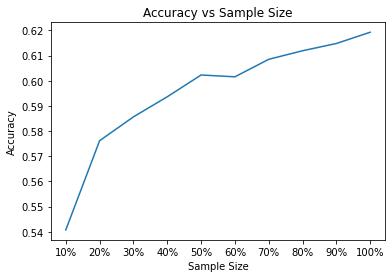

In [123]:
# plot accuracy vs data_sizee for size_logreg_df
plt.plot(logreg_sample_dict_df.index, logreg_sample_dict_df["accuracy"])
plt.xlabel("Sample Size")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Sample Size")
plt.show()


However, this was not the case when looking at the effect of training size on time. Rate seems to be 
consistent

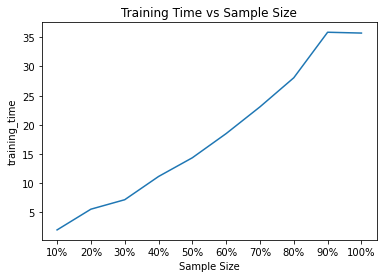

In [125]:
# plot training time vs data_sizee for size_logreg_df
plt.plot(logreg_sample_dict_df.index, logreg_sample_dict_df["training_time"])
plt.xlabel("Sample Size")
plt.ylabel("training_time")
plt.title("Training Time vs Sample Size")
plt.show()


### Naive Bayes

Secondly, the Multinomial Naive Bayes model was tested on 10 different training size

In [116]:
nb_best = MultinomialNB(alpha=0.1)
nb_sample_dict = {}
nb_sample_dict = test_sample_size_model(data, nb_best, sample_size, nb_sample_dict)

Testing out sample size of 10%


Testing out sample size of 20%


Testing out sample size of 30%


Testing out sample size of 40%


Testing out sample size of 50%


Testing out sample size of 60%


Testing out sample size of 70%


Testing out sample size of 80%


Testing out sample size of 90%


Testing out sample size of 100%




In [118]:
nb_sample_dict

{'10%': {'accuracy': 0.5463917525773195,
  'training_time': 0.010508060455322266,
  'eval_present_weighted': 0.54418578871522,
  'data_size': 30069},
 '20%': {'accuracy': 0.5753242434319921,
  'training_time': 0.024690866470336914,
  'eval_present_weighted': 0.5611212725861879,
  'data_size': 60137},
 '30%': {'accuracy': 0.5846358496840705,
  'training_time': 0.03351306915283203,
  'eval_present_weighted': 0.566749806008203,
  'data_size': 90206},
 '40%': {'accuracy': 0.5878782840039907,
  'training_time': 0.03153419494628906,
  'eval_present_weighted': 0.5689820973284558,
  'data_size': 120275},
 '50%': {'accuracy': 0.5976055869637512,
  'training_time': 0.0365138053894043,
  'eval_present_weighted': 0.5748786165613569,
  'data_size': 150344},
 '60%': {'accuracy': 0.5957210952222591,
  'training_time': 0.04024386405944824,
  'eval_present_weighted': 0.574769057384621,
  'data_size': 180412},
 '70%': {'accuracy': 0.6017387999429902,
  'training_time': 0.045993804931640625,
  'eval_pres

In [119]:
nb_sample_df = pd.DataFrame.from_dict(nb_sample_dict, orient='index')

MNB showed similar trend to Logistiic Regression, with higher rate when sample size < 0.4%, but starts diminishing 
as it approaches 100%

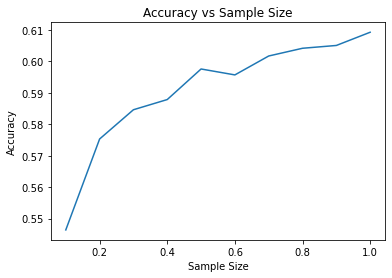

In [761]:
# plot accuracy vs data_sizee for size_logreg_df
plt.plot(nb_sample_df.index, nb_sample_df["accuracy"])
plt.xlabel("Sample Size")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Sample Size")
plt.show()


However, the effect of sample size on training time seems to be more fluctuating, although 
its change isn't as significant as the patterns observed in Accuracy vs Sample Size

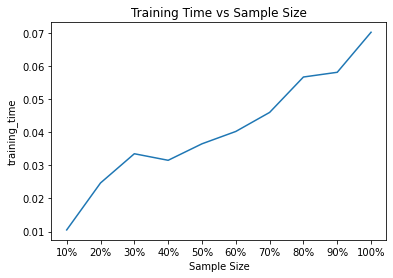

In [120]:
# plot training time vs data_sizee for size_logreg_df
plt.plot(nb_sample_df.index, nb_sample_df["training_time"])
plt.xlabel("Sample Size")
plt.ylabel("training_time")
plt.title("Training Time vs Sample Size")
plt.show()


### FastText

Lastly, FastText was tested on 10 different sample sizes

In [137]:
def fasttext_sample_size(df, sample_size_test, dict):
    for sample_size in sample_size_test:
        print("Testing out FastTextsample size of {}%".format(int(sample_size*100)))
        if sample_size == 1:
            df_sample = df
        else:
            df_sample = df.sample(frac=sample_size, random_state=12)

        data_size = len(df_sample)

        df_sample['fasttext'] = df_sample['y1'].apply(lambda x: '__label__' + str(x))

        # train_test split
        train, test = train_test_split(df_sample, test_size=0.1, random_state=66)

  
        train[['fasttext', 'no_sticky']].to_csv('train.txt', index = False, sep = ' ',header = None, quoting = csv.QUOTE_NONE, quotechar = "", escapechar = " ")
        test[['fasttext', 'no_sticky']].to_csv('test.txt', index = False, sep = ' ',header = None, quoting = csv.QUOTE_NONE, quotechar = "", escapechar = " ")
        start=time.time()
        fasttext_model = fasttext.train_supervised(input='train.txt')
        stop=time.time()
        fasttext_time = stop-start
        print("time taken to train = " + str(fasttext_time))

        # create eval score
        # normal function to showcase

        test_text = test['no_sticky'].tolist()

        label_1_pred_list = []
        label_2_pred_list = []
        label_3_pred_list = []
        for question in test_text:
            fasttext_prediction = fasttext_model.predict(question, k=3)[0]
            # convert '__label__x' to 'x'
            fasttext_prediction1 = int(fasttext_prediction[0].split('__label__')[1])
            fasttext_prediction2 = int(fasttext_prediction[1].split('__label__')[1])
            fasttext_prediction3 = int(fasttext_prediction[2].split('__label__')[1])

            # add to list
            label_1_pred_list.append(fasttext_prediction1)
            label_2_pred_list.append(fasttext_prediction2)
            label_3_pred_list.append(fasttext_prediction3)
        test['label_1_pred'] = label_1_pred_list
        test['label_2_pred'] = label_2_pred_list
        test['label_3_pred'] = label_3_pred_list

        # create new column where it checks to see whether label is in prediction 1, 2 and 3
        test["compare_y1"] = np.where(test["y1"] == test["label_1_pred"], "1", np.where(test["y1"] == test["label_2_pred"], "2", 
                                np.where(test["y1"] == test["label_3_pred"], "3", "0")))
        test["compare_y2"] = np.where(test["y2"] == test["label_1_pred"], "1", np.where(test["y2"] == test["label_2_pred"], "2",
                                np.where(test["y2"] == test["label_3_pred"], "3", "0")))
        test["compare_y3"] = np.where(test["y3"] == test["label_1_pred"], "1", np.where(test["y3"] == test["label_2_pred"], "2",
                                np.where(test["y3"] == test["label_3_pred"], "3", "0")))

        # y1_present = (len(test) - len(test[test['compare_y1'] == "0"])) * 2.1
        # y2_present = (len(test) - len(test[test['compare_y2'] == "0"])) * 0.6
        # y3_present = (len(test) - len(test[test['compare_y3'] == "0"])) * 0.3

        # y_present = (y1_present + y2_present + y3_present)/3

        # eval_present_weighted_fasttext = y_present/len(test)

        test["eval_y1"] = np.where(test["compare_y1"] == "1", 2.1, np.where(test["compare_y1"] == "2", 1.15, np.where(test["compare_y1"] == "3", 1.15, 0)))
        test["eval_y2"] = np.where(test["compare_y2"] == "2", 0.6, np.where(test["compare_y2"] == "1", 0.3, np.where(test["compare_y1"] == "3", 0.3, 0)))
        test["eval_y3"] = np.where(test["compare_y3"] == "3", 0.3, np.where(test["compare_y3"] == "1", 0.15, np.where(test["compare_y1"] == "2", 0.15, 0)))
        test['eval_score'] = (test["eval_y1"] + test["eval_y2"] + test["eval_y3"])/3

        # mean of eval_score
        eval_present_weighted_fasttext = test["eval_score"].mean()

        # calculate accuracy
        fasttext_y_pred = test['label_1_pred'].tolist()
        fasttext_y_true = test['y1'].tolist()
        fasttext_accuracy = accuracy_score(fasttext_y_true, fasttext_y_pred)
        

        dict = add_model_results(dict, (str(int(sample_size*100))+"%"),fasttext_accuracy, fasttext_time, eval_present_weighted_fasttext, data_size)
    return dict

In [138]:
fasttext_dict = {}

In [139]:
fasttext_dict = fasttext_sample_size(data_fast_text, sample_size, fasttext_dict)

Testing out FastTextsample size of 10%


Read 0M words
Number of words:  20449
Number of labels: 10
Progress: 100.0% words/sec/thread:  843632 lr:  0.000000 avg.loss:  1.581680 ETA:   0h 0m 0s


time taken to train = 0.42466092109680176
Testing out FastTextsample size of 20%


Read 0M words
Number of words:  27727
Number of labels: 10
Progress: 100.0% words/sec/thread: 1250541 lr:  0.000000 avg.loss:  1.347401 ETA:   0h 0m 0s


time taken to train = 0.558643102645874
Testing out FastTextsample size of 30%


Read 1M words
Number of words:  32636
Number of labels: 10
Progress: 100.0% words/sec/thread: 1502172 lr:  0.000000 avg.loss:  1.284924 ETA:   0h 0m 0s


time taken to train = 0.6309959888458252
Testing out FastTextsample size of 40%


Read 1M words
Number of words:  36260
Number of labels: 10
Progress: 100.0% words/sec/thread: 1465973 lr:  0.000000 avg.loss:  1.250324 ETA:   0h 0m 0s


time taken to train = 0.8468410968780518
Testing out FastTextsample size of 50%


Read 1M words
Number of words:  39417
Number of labels: 10
Progress: 100.0% words/sec/thread: 1413372 lr:  0.000000 avg.loss:  1.232265 ETA:   0h 0m 0s


time taken to train = 1.0855660438537598
Testing out FastTextsample size of 60%


Read 2M words
Number of words:  41975
Number of labels: 10
Progress: 100.0% words/sec/thread: 1521139 lr:  0.000000 avg.loss:  1.218992 ETA:   0h 0m 0s


time taken to train = 1.2035009860992432
Testing out FastTextsample size of 70%


Read 2M words
Number of words:  44289
Number of labels: 10
Progress: 100.0% words/sec/thread: 1050397 lr:  0.000000 avg.loss:  1.219326 ETA:   0h 0m 0s


time taken to train = 1.93864107131958
Testing out FastTextsample size of 80%


Read 2M words
Number of words:  46260
Number of labels: 10
Progress: 100.0% words/sec/thread: 1354824 lr:  0.000000 avg.loss:  1.205210 ETA:   0h 0m 0s


time taken to train = 1.7765250205993652
Testing out FastTextsample size of 90%


Read 3M words
Number of words:  48080
Number of labels: 10
Progress: 100.0% words/sec/thread: 1435431 lr:  0.000000 avg.loss:  1.201326 ETA:   0h 0m 0s


time taken to train = 1.9027369022369385
Testing out FastTextsample size of 100%


Read 3M words
Number of words:  49775
Number of labels: 10
Progress: 100.0% words/sec/thread: 1213784 lr:  0.000000 avg.loss:  1.192656 ETA:   0h 0m 0s


time taken to train = 2.4371373653411865


In [140]:
fasttext_sample_dict_df = pd.DataFrame.from_dict(fasttext_dict, orient='index')

In [141]:
fasttext_sample_dict_df

,accuracy,training_time,eval_present_weighted,data_size
10%,0.529764,0.424661,0.534276,30069
20%,0.582641,0.558643,0.562258,60137
30%,0.592063,0.630996,0.571742,90206
40%,0.599767,0.846841,0.573285,120275
50%,0.607649,1.085566,0.579302,150344
60%,0.616063,1.203501,0.584631,180412
70%,0.614661,1.938641,0.585085,210481
80%,0.619913,1.776525,0.586554,240550
90%,0.614810,1.902737,0.586543,270618
100%,0.620273,2.437137,0.587552,300687


Like the previous two models, FastText observed the same pattern where the rate starts to slow after 20-30% 
training size

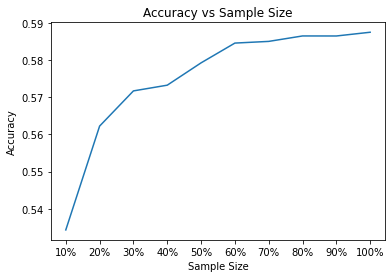

In [144]:
# plot accuracy vs data_sizee for size_logreg_df
plt.plot(fasttext_sample_dict_df.index, fasttext_sample_dict_df["eval_present_weighted"])
plt.xlabel("Sample Size")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Sample Size")
plt.show()


Effect on training time also seemed to fluctuate, although like the Naive Bayes model, its changes 
are not as significant as the pattern found in the Accuracy vs Sample Size

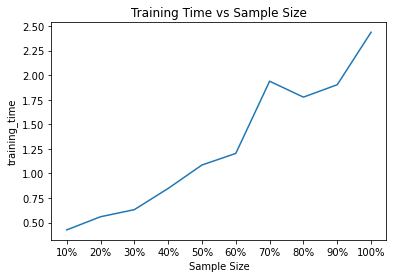

In [145]:
# plot training time vs data_sizee for size_logreg_df
plt.plot(fasttext_sample_dict_df.index, fasttext_sample_dict_df["training_time"])
plt.xlabel("Sample Size")
plt.ylabel("training_time")
plt.title("Training Time vs Sample Size")
plt.show()


### Comparison of performance

The performance of these three models are compared in the next series of graphs

The indexes are converted into a float format

In [194]:
# remove % from string
float_index = []
for i in nb_sample_df.index:
    float_index.append(float(i[:-1])/100)
nb_sample_df.index = float_index
logreg_sample_dict_df.index = float_index
fasttext_sample_dict_df.index = float_index

#### Looking at sample size vs model performance

All three models showed high increase in evaluation score when sample size is at or less than 20%, but the rate 
of score increase starts plateauing as sample size approaches 100%

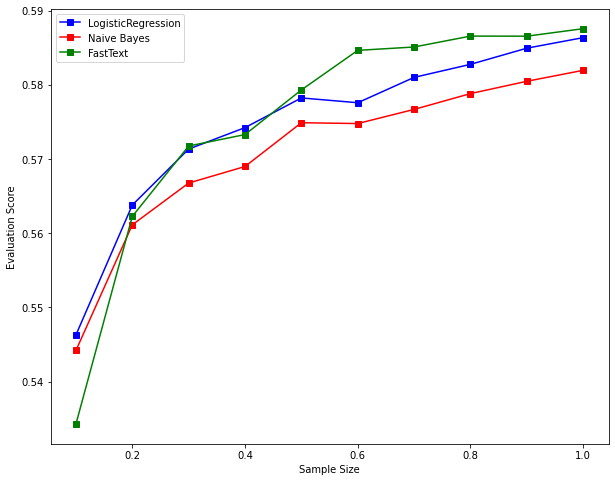

In [762]:
# plot line graph of sample size vs accuracy in nb_sample_df
plt.figure(figsize=(10,8))
ax1 = plt.subplot(1,1,1)

ax1.plot(logreg_sample_dict_df.index, logreg_sample_dict_df['eval_present_weighted'], label='LogisticRegression', marker='s', color='blue')
ax1.plot(nb_sample_df.index, nb_sample_df['eval_present_weighted'], label='Naive Bayes', marker='s', color='red')
ax1.plot(fasttext_sample_dict_df.index, fasttext_sample_dict_df['eval_present_weighted'], label='FastText', marker='s', color='green')

ax1.set_xlabel('Sample Size')
ax1.set_ylabel('Evaluation Score')
ax1.legend()


plt.show()



The rate at which the model score changes between 10% sample size interval will now be looked at

In [195]:
nb_score = nb_sample_df["eval_present_weighted"]
fasttext_score = fasttext_sample_dict_df["eval_present_weighted"]
logreg_score = logreg_sample_dict_df["eval_present_weighted"]

sample_df = pd.concat([nb_score, fasttext_score, logreg_score], axis=1)
# sample_df.columns(["nb_score", "fasttext_score", "logreg_score"])

In [196]:
# change column name of sample_df
sample_df.columns = ["Naive Bayes", "FastText", "Logistic Regression"]
sample_df.index = nb_sample_df['data_size']

In [740]:
# calculate the difference between the data size and the accuracy
sample_df['Naive Bayes Diff'] = sample_df['Naive Bayes'] - sample_df['Naive Bayes'].shift(1)
sample_df['FastText Diff'] = sample_df['FastText'] - sample_df['FastText'].shift(1)
sample_df['Logistic Regression Diff'] = sample_df['Logistic Regression'] - sample_df['Logistic Regression'].shift(1)

In [741]:
sample_df[['Naive Bayes Diff', 'FastText Diff', 'Logistic Regression Diff']]

,Naive Bayes Diff,FastText Diff,Logistic Regression Diff
data_size,,,
30069,NaN,NaN,NaN
60137,0.016935,0.027982,0.017506
90206,0.005629,0.009484,0.007544
120275,0.002232,0.001543,0.002890
150344,0.005897,0.006017,0.003998
180412,-0.000110,0.005330,-0.000646
210481,0.001904,0.000454,0.003417
240550,0.002132,0.001469,0.001758
270618,0.001660,-0.000010,0.002176


The graph below emphasised what was initially observed in the previous graphs. All models showed the highest increase 
in model performance when sample size was lower than 100,000. However, after that threshsold, the rate 
of increase starts to diminish

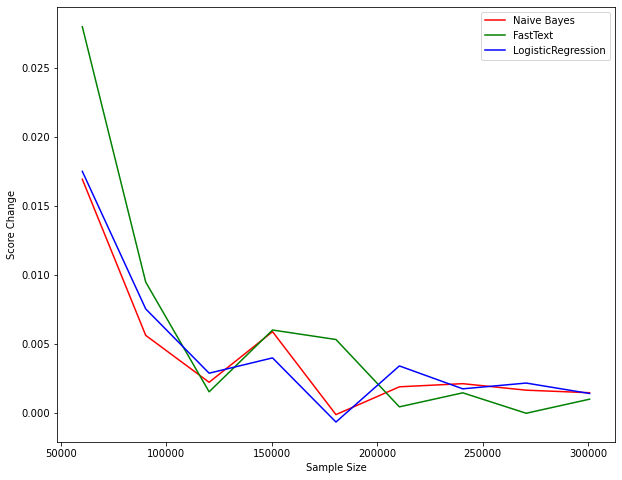

In [748]:
# Plot the rate of accuracy
plt.figure(figsize=(10,8))
ax1 = plt.subplot(1,1,1)
ax1.plot(sample_df.index, sample_df['Naive Bayes Diff'], label='Naive Bayes', color='red')
ax1.plot(sample_df.index, sample_df['FastText Diff'], label='FastText', color='green')
ax1.plot(sample_df.index, sample_df['Logistic Regression Diff'], label='LogisticRegression', color='blue')
ax1.set_xlabel('Sample Size')
ax1.set_ylabel('Score Change')
ax1.legend()
plt.show()


In [ ]:
# normalise training time for each model
nb_sample_df['training_time_norm'] = nb_sample_df['training_time'] / nb_sample_df['training_time'].max()
logreg_sample_dict_df['training_time_norm'] = logreg_sample_dict_df['training_time'] / logreg_sample_dict_df['training_time'].max()
fasttext_sample_dict_df['training_time_norm'] = fasttext_sample_dict_df['training_time'] / fasttext_sample_dict_df['training_time'].max()


#### Model Performance vs Training Time

Next, the effect of training time on model performance was observed. We wanted to see whether higher training 
time also leads to a diminishing increase in model performance

To create a comparative graph, the time metric was normalised.

In [ ]:
# normalise training time for each model
nb_sample_df['training_time_norm'] = nb_sample_df['training_time'] / nb_sample_df['training_time'].max()
logreg_sample_dict_df['training_time_norm'] = logreg_sample_dict_df['training_time'] / logreg_sample_dict_df['training_time'].max()
fasttext_sample_dict_df['training_time_norm'] = fasttext_sample_dict_df['training_time'] / fasttext_sample_dict_df['training_time'].max()


As a result, a similar pattern was observed alongside the Score vs Sample Size. At shorter training time, 
all models exhibit big changes in evaluation score, but as training time increases, rate starts plateauing 
as well

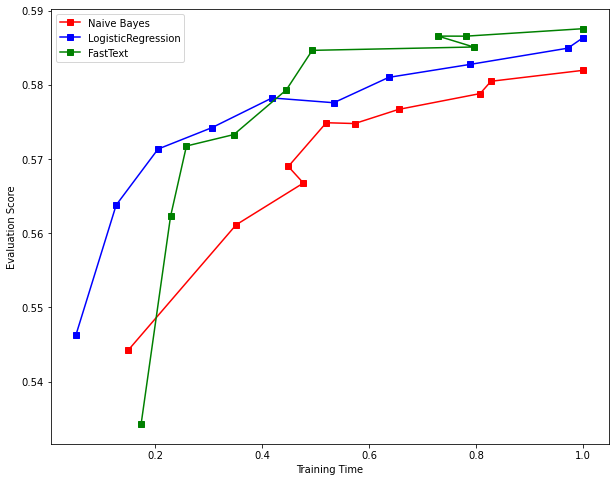

In [735]:
# plot line graph of sample size vs accuracy in nb_sample_df
plt.figure(figsize=(10,8))
ax1 = plt.subplot(1,1,1)
ax1.plot(nb_sample_df['training_time_norm'], nb_sample_df['eval_present_weighted'], label='Naive Bayes', marker = 's', color='red')
ax1.plot(logreg_sample_dict_df['training_time_norm'], logreg_sample_dict_df['eval_present_weighted'], label='LogisticRegression', marker='s', color='blue')
ax1.plot(fasttext_sample_dict_df['training_time_norm'], fasttext_sample_dict_df['eval_present_weighted'], label='FastText', marker='s', color='green')
ax1.set_xlabel('Training Time')
ax1.set_ylabel('Evaluation Score')

ax1.legend()



#### Sample Size vs Training Time

Lastly, the effect of training size was looked at on the training time

This graph does show that with higher sample size, training time increases. However, it is hard to compare as the 
trraining time is not normalised.

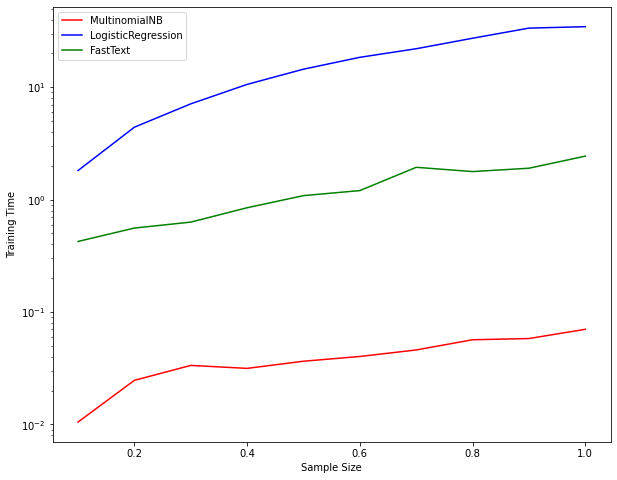

In [773]:
# plot line graph of sample size vs accuracy in nb_sample_df
plt.figure(figsize=(10,8))
ax1 = plt.subplot(1,1,1)
ax1.plot(nb_sample_df.index, nb_sample_df['training_time'], label='MultinomialNB', color='red')
ax1.plot(logreg_sample_dict_df.index, logreg_sample_dict_df['training_time'], label='LogisticRegression', color='blue')
ax1.plot(fasttext_sample_dict_df.index, fasttext_sample_dict_df['training_time'], label='FastText', color='green')
ax1.set_xlabel('Sample Size')
ax1.set_ylabel('Training Time')
# log y axis
ax1.set_yscale('log')
ax1.legend()
plt.show()

This graph below showed a better comparison as time is normalised. Interestingly, the effect of sample size 
on training time seems to be linearly proportional, meaning that no matter how high the training size is, tiime 
will also increase proportionally

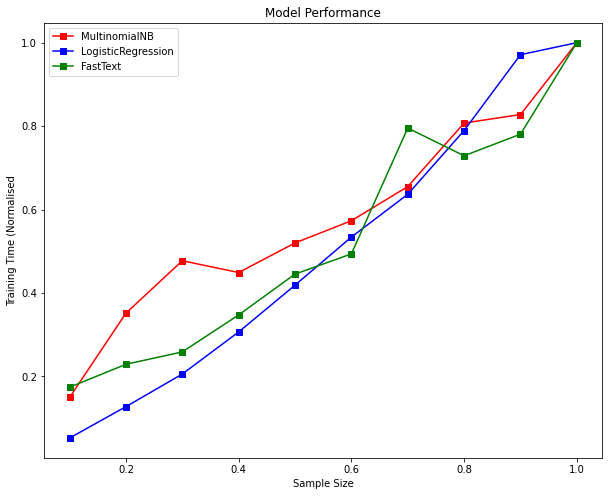

In [775]:
# plot line graph of sample size vs accuracy in nb_sample_df
plt.figure(figsize=(10,8))
ax1 = plt.subplot(1,1,1)
ax1.plot(nb_sample_df.index, nb_sample_df['training_time_norm'], label='MultinomialNB', marker='s', color='red')
ax1.plot(logreg_sample_dict_df.index, logreg_sample_dict_df['training_time_norm'], label='LogisticRegression', marker='s', color='b')
ax1.plot(fasttext_sample_dict_df.index, fasttext_sample_dict_df['training_time_norm'], label='FastText', marker='s', color='green')
ax1.set_xlabel('Sample Size')
ax1.set_ylabel('Training Time (Normalised')
ax1.set_title('Model Performance')
# log y axis
# ax1.set_yscale('log')
ax1.legend()
plt.show()

## Insights

The following insights can be made:
1. `Sample Size vs Model Performance` - Models showed a logarithmic growth: highest rate of increase in 
model performance when sample size is lower than 30% (n=100000), but gains start decreasing as sample size increases.

2. `Model Performance vs Training Time` - Models also showed a logarithmic growth: highest rate of increase in 
model performance when training time is short, but gains start decreasing as training takes longer.

3. `Sample Size vs Training Time` -  Models showed linear growth: as training size increases, training time will 
also proportionally increase. Rate was maintained throughout

##